In [ ]:
# Install required packages
!pip install scikit-posthocs --quiet
!pip install matplotlib seaborn pandas --quiet
!pip install pingouin --quiet
!pip install scipy --quiet
!pip install statsmodels --quiet
!pip install pymannkendall --quiet
!pip install pyreadr --quiet

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency, shapiro, kruskal, kendalltau,chisquare
import scikit_posthocs as sp
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.multitest import multipletests



# Load data
URL_DATA = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'

df = pd.read_parquet(URL_DATA)
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['dayofweek'] = df['date'].dt.day_name()
df["blood_type"] = df["blood_type"].str.upper()
valid_types = ["A", "B", "AB", "O"]
df = df[df["blood_type"].isin(valid_types)]



In [ ]:
# Basic EDA
print("First 5 rows of the DataFrame:")
display(df.head())

print("\nDataFrame Info:")
df.info()

print("\nShape:")
shape = df.shape[0]
display(df.shape)

print("\nData Types:")
display(df.dtypes)

print("\nMissing values per column:")
display(df.isnull().sum())

print("\nDescriptive Statistics:")
display(df.describe())

First 5 rows of the DataFrame:


,date,state,blood_type,donations,month,year,dayofweek
93145,2006-01-01,Johor,A,19,1,2006,Sunday
93146,2006-01-02,Johor,A,4,1,2006,Monday
93147,2006-01-03,Johor,A,2,1,2006,Tuesday
93148,2006-01-04,Johor,A,7,1,2006,Wednesday
93149,2006-01-05,Johor,A,3,1,2006,Thursday



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 372580 entries, 93145 to 465724
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        372580 non-null  datetime64[ns]
 1   state       372580 non-null  object        
 2   blood_type  372580 non-null  object        
 3   donations   372580 non-null  int64         
 4   month       372580 non-null  int32         
 5   year        372580 non-null  int32         
 6   dayofweek   372580 non-null  object        
dtypes: datetime64[ns](1), int32(2), int64(1), object(3)
memory usage: 19.9+ MB

Shape:


(372580, 7)


Data Types:


(372580, 7)


Missing values per column:


,0
date,0
state,0
blood_type,0
donations,0
month,0
year,0
dayofweek,0



Descriptive Statistics:


,date,donations,month,year
count,372580,372580.000000,372580.000000,372580.000000
mean,2015-10-23 00:00:00,24.706463,6.451361,2015.314724
min,2006-01-01 00:00:00,0.000000,1.000000,2006.000000
25%,2010-11-27 00:00:00,3.000000,3.000000,2010.000000
50%,2015-10-23 00:00:00,10.000000,6.000000,2015.000000
75%,2020-09-17 00:00:00,28.000000,9.000000,2020.000000
max,2025-08-13 00:00:00,1048.000000,12.000000,2025.000000
std,NaN,43.808726,3.438555,5.665802


In [ ]:
import pandas as pd

def clip_outliers_by_group(df, group_cols, value_col):
    """
    Replace outliers with the nearest bound (lower/upper) within each group.

    Parameters:
        df (pd.DataFrame): The input DataFrame
        group_cols (list): Columns to group by (e.g., ['state', 'month'])
        value_col (str): Name of the column in which to clip outliers

    Returns:
        pd.DataFrame: Modified DataFrame with clipped outliers
    """
    df = df.copy()

    def clip_group(group):
        Q1 = group[value_col].quantile(0.25)
        Q3 = group[value_col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        group[value_col] = group[value_col].clip(lower=lower, upper=upper)
        return group

    return df.groupby(group_cols, group_keys=False).apply(clip_group)

# שימוש:
df = clip_outliers_by_group(
    df=df,
    group_cols=['state','year','blood_type'],
    value_col='donations'
)

print(df.shape[0]/shape)


1.0


/tmp/ipython-input-2008574844.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby(group_cols, group_keys=False).apply(clip_group)


In [ ]:
# Chi-square goodness-of-fit test
observed = df.groupby('blood_type')['donations'].sum()
# Remove 'all' category if present as it's a sum of others
if 'all' in observed.index:
    observed = observed.drop('all')
print(observed)
total_donations = observed.sum()
expected_ratios = {'A': 0.27, 'AB': 0.06, 'B': 0.23,'O': 0.44}
expected = pd.Series({bt: p * total_donations for bt, p in expected_ratios.items()})

print(expected)
chi2_stat = ((observed - expected)**2 / expected).sum()
from scipy.stats import chi2
p_value = 1 - chi2.cdf(chi2_stat, df=len(expected)-1)
print(f"Chi-square statistic: {chi2_stat:.2f}, p-value: {p_value:.4f}")

# גודל אפקט (Cramér's V)
V = np.sqrt(chi2_stat / total_donations)
print(f"Cramér's V: {V:.4f}")

blood_type
A     2217443.875
AB     549675.875
B     2439094.625
O     3732416.375
Name: donations, dtype: float64
A     2.413430e+06
AB    5.363178e+05
B     2.055885e+06
O     3.932998e+06
dtype: float64
Chi-square statistic: 97906.52, p-value: 0.0000
Cramér's V: 0.1047


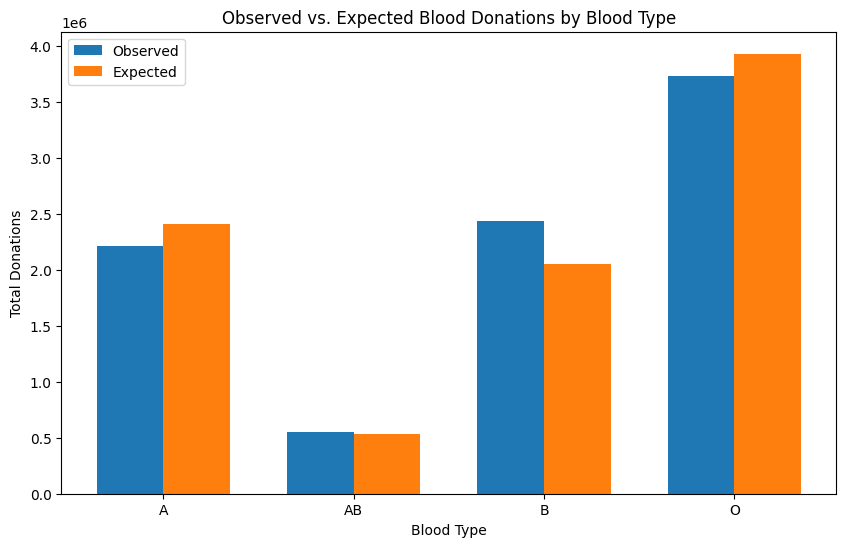

In [ ]:
# Plotting the observed and expected frequencies
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.35
index = np.arange(len(observed.index))

bar1 = ax.bar(index, observed, bar_width, label='Observed')
bar2 = ax.bar(index + bar_width, expected, bar_width, label='Expected')

ax.set_xlabel('Blood Type')
ax.set_ylabel('Total Donations')
ax.set_title('Observed vs. Expected Blood Donations by Blood Type')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(observed.index)
ax.legend()

plt.show()

                state          chi2  pval  pval_bonf  cramers_v
0               Johor   6788.114014   0.0        0.0   0.105405
1               Kedah  15134.830206   0.0        0.0   0.138522
2            Kelantan   2424.674573   0.0        0.0   0.106351
3              Melaka   4348.126457   0.0        0.0   0.091301
4     Negeri Sembilan   2961.993109   0.0        0.0   0.101738
5              Pahang   3517.504222   0.0        0.0   0.121583
6               Perak   8503.499053   0.0        0.0   0.113223
7        Pulau Pinang   4384.875409   0.0        0.0   0.098583
8               Sabah   8544.531850   0.0        0.0   0.132898
9             Sarawak  10942.167751   0.0        0.0   0.146824
10           Selangor   6260.504942   0.0        0.0   0.117112
11         Terengganu   6511.722186   0.0        0.0   0.145387
12  W.P. Kuala Lumpur  34616.239557   0.0        0.0   0.100778


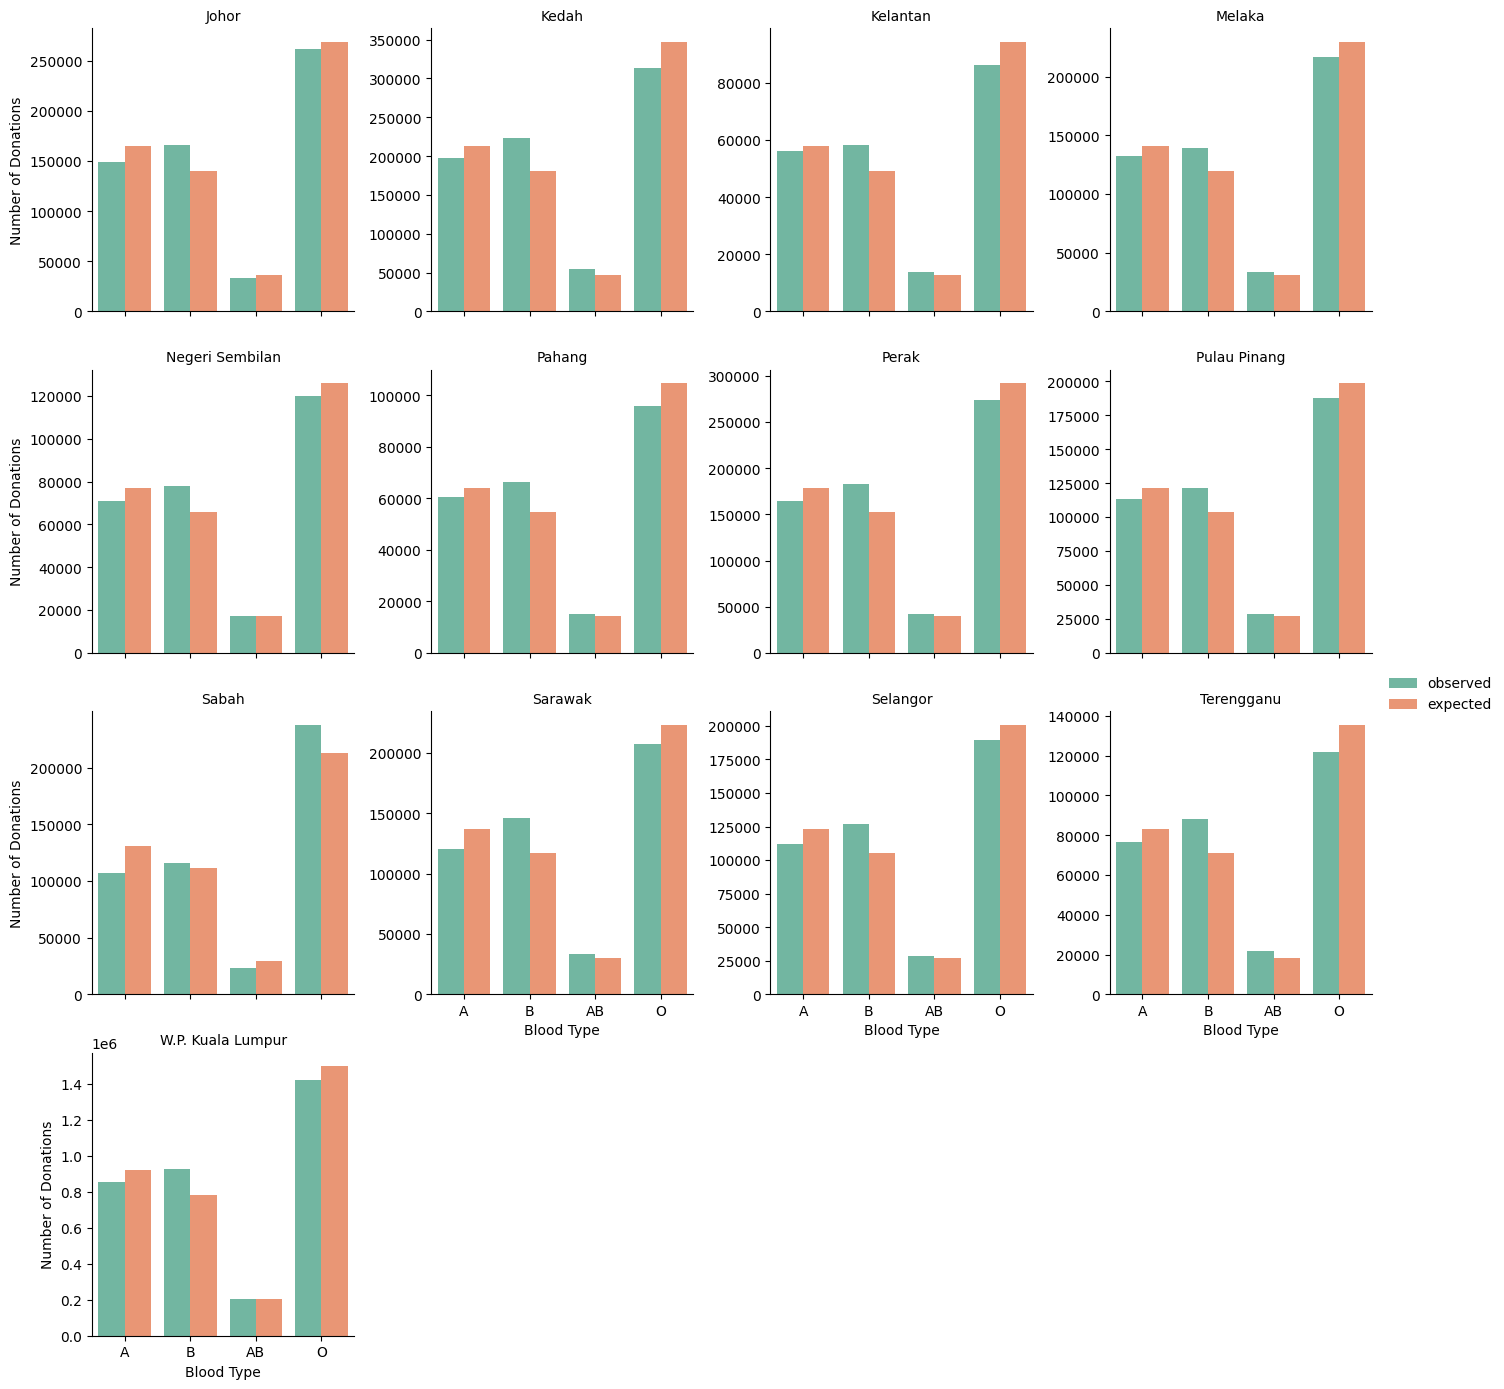

In [ ]:
# Storing results
results = []
plots_data = []

# Define blood types and expected distribution
blood_types = ["A", "B", "AB", "O"]
# Assuming the expected distribution is based on the overall observed proportions
# If there is a known population distribution, replace this with those values
total_donations = df["donations"].sum()
observed_counts = df.groupby('blood_type')['donations'].sum()
expected_distribution = expected_ratios = {'O': 0.44, 'A': 0.27, 'B': 0.23, 'AB': 0.06}


# Loop over states
for state, group in df.groupby("state"):
    # Actual sum of donations by blood type
    observed = group.groupby("blood_type")["donations"].sum().reindex(blood_types, fill_value=0)
    total = observed.sum()
    expected = [expected_distribution[bt] * total for bt in blood_types]

    # Chi-squared test
    chi2, pval = chisquare(f_obs=observed, f_exp=expected)

    # Effect size (Cramér's V)
    V = np.sqrt(chi2 / total)

    results.append({
        "state": state,
        "chi2": chi2,
        "pval": pval,
        "n": total,
        "cramers_v": V
    })

    # For plot preparation
    plots_data.append(pd.DataFrame({
        "state": state,
        "blood_type": blood_types,
        "observed": observed.values,
        "expected": expected
    }))


# Results table
results_df = pd.DataFrame(results)

# Bonferroni correction
results_df["pval_bonf"] = multipletests(results_df["pval"], method="bonferroni")[1]

# Plots – expected vs observed
plot_df = pd.concat(plots_data, ignore_index=True)
g = sns.catplot(
    data=plot_df.melt(id_vars=["state", "blood_type"], value_vars=["observed", "expected"]),
    kind="bar",
    x="blood_type",
    y="value",
    hue="variable",
    col="state",
    col_wrap=4,
    height=3.5,
    sharey=False,
    palette="Set2"
)
g.set_titles("{col_name}")
g.set_axis_labels("Blood Type", "Number of Donations")
g._legend.set_title("")

# Display sorted table
results_df = results_df.sort_values("pval_bonf")
print(results_df[["state", "chi2", "pval", "pval_bonf", "cramers_v"]])

בדיקת קורלציה בין סוגי דם על כל מלזיה ובתוך מלזיה

In [ ]:
# assumptions_checks.py
# -*- coding: utf-8 -*-
from typing import List, Optional, Dict, Any, Tuple
import numpy as np
import pandas as pd

# Optional libraries (if available – improve the checks)
try:
    from scipy.stats import pearsonr, spearmanr, levene
except Exception:
    pearsonr = spearmanr = levene = None

try:
    from sklearn.covariance import MinCovDet
except Exception:
    MinCovDet = None


# =========================
#  General helper tools
# =========================

def _nzv_flags(df: pd.DataFrame, cols: List[str], tol: float = 1e-12) -> pd.DataFrame:
    """Detect variables with near-zero variance (may harm PCA)."""
    stats = []
    for c in cols:
        x = df[c].dropna().astype(float).values
        stats.append({
            "variable": c,
            "n_non_missing": x.size,
            "std": float(np.std(x, ddof=1)) if x.size > 1 else np.nan,
            "var_near_zero": (np.std(x, ddof=1) < tol) if x.size > 1 else True
        })
    return pd.DataFrame(stats).sort_values("var_near_zero", ascending=False).reset_index(drop=True)


def _scale_diagnostics(df: pd.DataFrame, cols: List[str]) -> pd.DataFrame:
    """Scaling diagnostics: ranges, standard deviations, max/min ratio between variables."""
    rows = []
    for c in cols:
        x = df[c].dropna().astype(float).values
        rows.append({
            "variable": c,
            "mean": np.nanmean(x),
            "std": np.nanstd(x, ddof=1) if x.size > 1 else np.nan,
            "min": np.nanmin(x) if x.size else np.nan,
            "max": np.nanmax(x) if x.size else np.nan,
            "range": (np.nanmax(x) - np.nanmin(x)) if x.size else np.nan
        })
    diag = pd.DataFrame(rows)
    # Simple metric: max standard deviation to minimum ratio (identifies sharp scale differences)
    diag["std_ratio_to_min"] = diag["std"] / diag["std"].replace(0, np.nan).min()
    return diag.sort_values("std_ratio_to_min", ascending=False)


def _pairwise_corrs(df: pd.DataFrame, cols: List[str]) -> Dict[str, pd.DataFrame]:
    """Pearson and Spearman correlation matrices (check linearity/monotonicity)."""
    X = df[cols].astype(float)
    pear = X.corr(method="pearson")
    spear = X.corr(method="spearman")
    return {"pearson": pear, "spearman": spear, "abs_diff": (pear.abs() - spear.abs()).abs()}


def _univariate_robust_outliers(df: pd.DataFrame, cols: List[str],
                                mz_thresh: float = 3.5, iqr_k: float = 1.5) -> pd.DataFrame:
    """
    Univariate outliers for each variable:
    - Modified Z (median and MAD)  |x - med| / MAD
    - IQR fences (1.5*IQR by default)
    """
    def modified_z(x: np.ndarray) -> np.ndarray:
        med = np.median(x)
        mad = np.median(np.abs(x - med))
        if mad == 0:
            return np.full_like(x, np.nan, dtype=float)
        return 0.6745 * (x - med) / mad

    rows = []
    for c in cols:
        x = df[c].astype(float).values
        mz = modified_z(x)
        q1, q3 = np.nanpercentile(x, 25), np.nanpercentile(x, 75)
        iqr = q3 - q1
        lo, hi = q1 - iqr_k * iqr, q3 + iqr_k * iqr
        mask = (np.abs(mz) > mz_thresh) | (x < lo) | (x > hi)
        idxs = np.where(mask)[0]
        for i in idxs:
            rows.append({"variable": c, "index": i, "value": x[i],
                         "modZ": mz[i], "IQR_lo": lo, "IQR_hi": hi})
    return pd.DataFrame(rows).sort_values(["variable", "index"]).reset_index(drop=True)


def _multivariate_outliers(df: pd.DataFrame, cols: List[str],
                           alpha: float = 0.001) -> pd.DataFrame:
    """
    Multivariate outliers (Mahalanobis) with MinCovDet if available, otherwise regular covariance.
    alpha≈0.001 -> strict threshold (approximation to quantile ellipse).
    """
    X = df[cols].astype(float).dropna()
    if X.empty:
        return pd.DataFrame(columns=["index", "mahal", "flag"])

    if MinCovDet is not None:
        mcd = MinCovDet(assume_centered=False, support_fraction=None, random_state=0).fit(X)
        mean = mcd.location_
        cov_inv = np.linalg.pinv(mcd.covariance_)
    else:
        mean = X.mean().values
        cov = np.cov(X.values, rowvar=False)
        cov_inv = np.linalg.pinv(cov)

    diffs = X.values - mean
    # d^2 = (x-μ)^T Σ^{-1} (x-μ)
    md2 = np.einsum("ij,jk,ik->i", diffs, cov_inv, diffs)
    # Approximate threshold: Chi-squared quantile with df=p
    from scipy.stats import chi2 as _chi2  # will be available in a regular SciPy environment
    thr = _chi2.ppf(1 - alpha, df=len(cols))
    flags = pd.DataFrame({
        "index": X.index,
        "mahal": md2,
        "flag": md2 > thr,
        "threshold": thr
    }).sort_values("mahal", ascending=False).reset_index(drop=True)
    return flags[flags["flag"]]


# =========================
#  Checks for PCA
# =========================

def check_pca_assumptions(df: pd.DataFrame,
                          feature_cols: List[str],
                          mz_thresh: float = 3.5,
                          iqr_k: float = 1.5,
                          alpha_mahal: float = 0.001) -> Dict[str, Any]:
    """
    Assumption checks before PCA:
    - Missing and zero-variance
    - Scaling (STD/ranges)
    - Linearity/monotonicity (Pearson vs Spearman)
    - Univariate and multivariate outliers
    Returns a dictionary with reports/flags.
    """
    report: Dict[str, Any] = {}

    # 0) Basic integrity
    sub = df[feature_cols].copy()
    report["missing_counts"] = sub.isna().sum().sort_values(ascending=False)
    report["rows_with_any_missing"] = int(sub.isna().any(axis=1).sum())

    # 1) Zero/near-zero variance
    report["near_zero_variance"] = _nzv_flags(sub, feature_cols)

    # 2) Scaling
    report["scaling_diagnostics"] = _scale_diagnostics(sub, feature_cols)
    report["recommend_standardize"] = bool(report["scaling_diagnostics"]["std_ratio_to_min"].max() > 5)

    # 3) Linear vs monotonic relationship
    report["correlations"] = _pairwise_corrs(sub, feature_cols)

    # 4) Univariate outliers
    report["univariate_outliers"] = _univariate_robust_outliers(sub, feature_cols,
                                                                mz_thresh=mz_thresh, iqr_k=iqr_k)

    # 5) Multivariate outliers
    try:
        report["multivariate_outliers"] = _multivariate_outliers(sub, feature_cols, alpha=alpha_mahal)
    except Exception as e:
        report["multivariate_outliers_error"] = str(e)
        report["multivariate_outliers"] = pd.DataFrame()

    # 6) Short textual summary
    notes = []
    if report["recommend_standardize"]:
        notes.append("Large scale differences detected – standardization (z-score) before PCA is recommended.")
    if not report["univariate_outliers"].empty or (isinstance(report["multivariate_outliers"], pd.DataFrame) and not report["multivariate_outliers"].empty):
        notes.append("Outliers detected that may affect component directions – consider handling/checking manually.")
    if (report["near_zero_variance"]["var_near_zero"].sum()) > 0:
        notes.append("Variables with near-zero variance detected – consider removing them before PCA.")
    report["summary_notes"] = notes

    return report


# =========================
#  Checks for ICC (ICC3k)
# =========================

def check_icc3k_assumptions(df: pd.DataFrame,
                            subject_col: str,
                            rater_col: str,
                            score_col: str,
                            use_median_in_levene: bool = True) -> Dict[str, Any]:
    """
    Assumption checks for ICC3k (Two-way mixed, average, consistency):
    - Completeness and format consistency (wide/balanced), missing values
    - Same scale and units (checks ranges/STDs between raters)
    - Homogeneity of variance between raters (Levene/Brown-Forsythe)
    - Outliers by rater and by subject (IQR/Modified-Z)
    Returns a dictionary with reports/flags.
    """
    rep: Dict[str, Any] = {}

    # 0) Completeness and panel balance
    piv = df.pivot_table(index=subject_col, columns=rater_col, values=score_col, aggfunc='mean')
    rep["subjects"] = piv.shape[0]
    rep["raters"] = piv.shape[1]
    rep["missing_cells"] = int(piv.isna().sum().sum())
    rep["is_balanced_panel"] = bool(piv.notna().all().all())

    # 1) Same scale (diagnostics: STDs/ranges per rater)
    per_rater = df.groupby(rater_col)[score_col].agg(['count', 'mean', 'std', 'min', 'max']).reset_index()
    per_rater["range"] = per_rater["max"] - per_rater["min"]
    rep["per_rater_scale"] = per_rater

    # 2) Homogeneity of variance between raters (Levene / Brown-Forsythe)
    if levene is not None:
        groups = [g[score_col].dropna().values for _, g in df.groupby(rater_col)]
        center = 'median' if use_median_in_levene else 'mean'
        stat, pval = levene(*groups, center=center)
        rep["levene_center"] = center
        rep["levene_stat"] = float(stat)
        rep["levene_pvalue"] = float(pval)
        rep["variances_homogeneous"] = bool(pval >= 0.05)
    else:
        rep["levene_error"] = "scipy.stats.levene not available."

    # 3) Outliers: by rater and by subject
    out_rows = []
    def modified_z(x: np.ndarray) -> np.ndarray:
        med = np.median(x)
        mad = np.median(np.abs(x - med))
        if mad == 0:
            return np.full_like(x, np.nan, dtype=float)
        return 0.6745 * (x - med) / mad

    # By rater
    for r, g in df.groupby(rater_col):
        x = g[score_col].astype(float).values
        mz = modified_z(x)
        q1, q3 = np.nanpercentile(x, 25), np.nanpercentile(x, 75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask = (np.abs(mz) > 3.5) | (x < lo) | (x > hi)
        idxs = np.where(mask)[0]
        for i in idxs:
            out_rows.append({rater_col: r, "where": "by_rater", "value": x[i],
                             "modZ": mz[i], "IQR_lo": lo, "IQR_hi": hi})

    # By subject (distribution of their scores between raters)
    for s, g in df.groupby(subject_col):
        x = g[score_col].astype(float).values
        if len(x) < 2:
            continue
        mz = modified_z(x)
        q1, q3 = np.nanpercentile(x, 25), np.nanpercentile(x, 75)
        iqr = q3 - q1
        lo, hi = q1 - 1.5 * iqr, q3 + 1.5 * iqr
        mask = (np.abs(mz) > 3.5) | (x < lo) | (x > hi)
        idxs = np.where(mask)[0]
        for i in idxs:
            out_rows.append({subject_col: s, "where": "by_subject", "value": x[i],
                             "modZ": mz[i], "IQR_lo": lo, "IQR_hi": hi})

    rep["outliers_flags"] = pd.DataFrame(out_rows)

    # 4) Technical summary
    notes = []
    if not rep["is_balanced_panel"] or rep["missing_cells"] > 0:
        notes.append("The panel is unbalanced/has missing values – consider systematic removal, imputation, or ICC with missing value handling.")
    # Large scale differences between raters
    if per_rater["std"].notna().sum() >= 2:
        ratio = per_rater["std"].max() / per_rater["std"].replace(0, np.nan).min()
        if ratio > 5:
            notes.append("Large scale differences between raters – consider within-rater standardization or using an appropriate ICC.")
    if "variances_homogeneous" in rep and not rep["variances_homogeneous"]:
        notes.append("Homogeneity of variance (Levene) rejected – this may bias the ICC.")
    if not rep["outliers_flags"].empty:
        notes.append("Outliers found by rater/subject – consider data verification or robust methods.")
    rep["summary_notes"] = notes

    return rep


'# =========================\n#  דוגמאות שימוש קצרות\n# =========================\nif __name__ == "__main__":\n    # ---- PCA ----\n    rng = np.random.default_rng(0)\n    df_pca = pd.DataFrame({\n        "x1": rng.normal(0, 1, 300),\n        "x2": rng.normal(0, 10, 300),          # סקייל שונה\n        "x3": rng.exponential(1.0, 300),       # לא נורמלי (מותר), ייתכן חריגים\n    })\n    pca_report = check_pca_assumptions(df_pca, ["x1", "x2", "x3"])\n    # דוגמא: הדפסת נקודות עיקריות\n    print("PCA notes:", pca_report["summary_notes"])\n\n    # ---- ICC ----\n    # נתונים ארוכים: subject, rater, score\n    n_subj, n_raters = 50, 3\n    df_icc = []\n    for s in range(n_subj):\n        base = rng.normal(50, 5)\n        for r in range(n_raters):\n            df_icc.append({"subject": s, "rater": f"R{r+1}", "score": base + rng.normal(0, 3)})\n    df_icc = pd.DataFrame(df_icc)\n    icc_report = check_icc3k_assumptions(df_icc, "subject", "rater", "score")\n    print("ICC notes:", icc_report[

--- PCA Assumption Checks ---

Missing Value Counts:
 donations    0
dtype: int64

Near Zero Variance Flags:



,variable,n_non_missing,std,var_near_zero
0,donations,372580,41.979546,False



Scaling Diagnostics:



,variable,mean,std,min,max,range,std_ratio_to_min
0,donations,23.991172,41.979546,0.0,495.5,495.5,1.0



Correlation Matrices (Pearson, Spearman, Absolute Difference):

--- Pearson Correlation Matrix ---


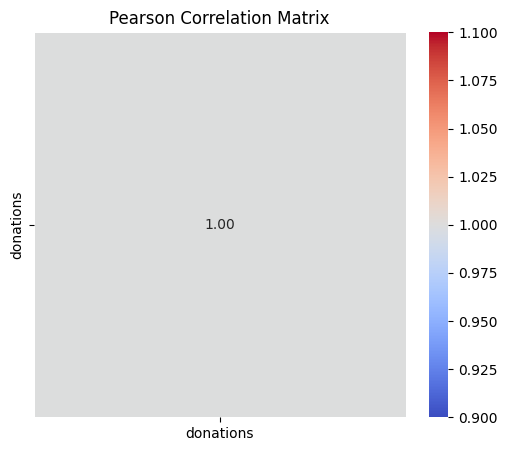

--- Spearman Correlation Matrix ---


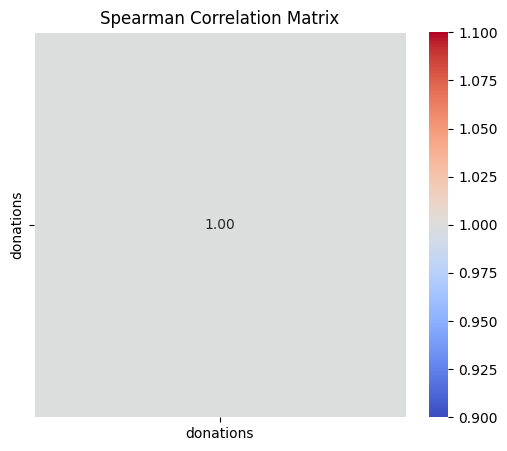

--- Abs_diff Correlation Matrix ---


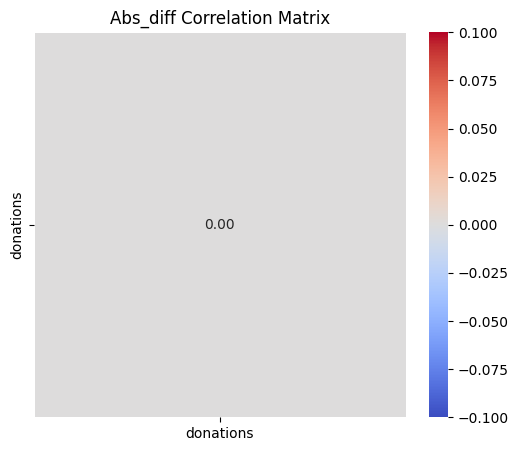


Univariate Outliers:



,variable,index,value,modZ,IQR_lo,IQR_hi
0,donations,1463,63.5,4.009528,-34.25,63.75
1,donations,1470,63.5,4.009528,-34.25,63.75
2,donations,1481,63.5,4.009528,-34.25,63.75
3,donations,1502,58.0,3.597333,-34.25,63.75
4,donations,1533,63.5,4.009528,-34.25,63.75
...,...,...,...,...,...,...
37393,donations,372486,79.0,5.171167,-34.25,63.75
37394,donations,372499,58.0,3.597333,-34.25,63.75
37395,donations,372519,61.0,3.822167,-34.25,63.75
37396,donations,372520,79.0,5.171167,-34.25,63.75



Multivariate Outliers:



,index,mahal,flag,threshold
0,372520,6103.077914,True,10.827566
1,372457,6103.077914,True,10.827566
2,372475,6103.077914,True,10.827566
3,372408,6103.077914,True,10.827566
4,372396,6103.077914,True,10.827566
...,...,...,...,...
92713,113617,11.181086,True,10.827566
92714,113528,11.181086,True,10.827566
92715,113606,11.181086,True,10.827566
92716,113483,11.181086,True,10.827566



Summary Notes:
 ['נמצאו חריגים שעלולים להשפיע על כיווני הרכיבים – שקול טיפול/בדיקה ידנית.']


--- ICC Assumption Checks (Example using date as subject, blood_type as rater) ---

Subjects: 7165

Raters: 4

Missing Cells: 0

Is Balanced Panel: True

Per Rater Scale Diagnostics:



,blood_type,count,mean,std,min,max,range
0,A,93145,23.806365,36.102576,0.0,302.0,302.0
1,AB,93145,5.901292,9.014676,0.0,79.0,79.0
2,B,93145,26.185996,38.934798,0.0,334.5,334.5
3,O,93145,40.071033,59.648499,0.0,495.5,495.5



Levene's Test Results:
 {'levene_center': 'median', 'levene_stat': 8771.415556275922, 'levene_pvalue': 0.0}

Outliers Flags:



,blood_type,where,value,modZ,IQR_lo,IQR_hi,date
0,A,by_rater,63.5,3.406225,-30.500,61.500,NaT
1,A,by_rater,63.5,3.406225,-30.500,61.500,NaT
2,A,by_rater,63.5,3.406225,-30.500,61.500,NaT
3,A,by_rater,63.5,3.406225,-30.500,61.500,NaT
4,A,by_rater,63.5,3.406225,-30.500,61.500,NaT
...,...,...,...,...,...,...,...
67897,NaN,by_subject,273.0,11.768862,-36.875,80.125,2025-08-12
67898,NaN,by_subject,131.0,6.438409,-18.500,73.500,2025-08-13
67899,NaN,by_subject,138.0,6.867636,-18.500,73.500,2025-08-13
67900,NaN,by_subject,81.0,3.372500,-18.500,73.500,2025-08-13



Summary Notes:
 ['הבדלי סקייל גדולים בין בודקים – בחן סטנדרטיזציה בתוך-בודק או שימוש ב-ICC מתאים.', 'דחיית הומוגניות שונות (Levene) – זה עלול להטות את ה-ICC.', 'נמצאו חריגים לפי בודק/נבדק – שקול אימות נתונים או שיטות חסונות.']


In [ ]:
# Run PCA assumption checks
feature_cols = ['donations'] # Replace with relevant numerical columns for PCA if needed
if not feature_cols or not all(col in df.columns for col in feature_cols):
    print("Feature columns for PCA not found or not specified correctly.")
    pca_report = {}
else:
    print("--- PCA Assumption Checks ---")
    pca_report = check_pca_assumptions(df, feature_cols)
    # Display selected parts of the PCA report
    print("\nMissing Value Counts:\n", pca_report.get("missing_counts"))
    print("\nNear Zero Variance Flags:\n")
    display(pca_report.get("near_zero_variance"))
    print("\nScaling Diagnostics:\n")
    display(pca_report.get("scaling_diagnostics"))
    print("\nCorrelation Matrices (Pearson, Spearman, Absolute Difference):\n")
    # Display correlation matrices as heatmaps for better visualization if possible
    corrs = pca_report.get("correlations")
    if corrs:
        for key, matrix in corrs.items():
            print(f"--- {key.capitalize()} Correlation Matrix ---")
            plt.figure(figsize=(6, 5))
            sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
            plt.title(f'{key.capitalize()} Correlation Matrix')
            plt.show()
    print("\nUnivariate Outliers:\n")
    display(pca_report.get("univariate_outliers"))
    print("\nMultivariate Outliers:\n")
    display(pca_report.get("multivariate_outliers"))
    print("\nSummary Notes:\n", pca_report.get("summary_notes"))


# Run ICC assumption checks
# Assuming 'date' can be treated as a subject and 'blood_type' as a rater for an example
# Note: This might not be a meaningful application of ICC for this data,
# but it demonstrates how to call the function.
print("\n\n--- ICC Assumption Checks (Example using date as subject, blood_type as rater) ---")
try:
    icc_report = check_icc3k_assumptions(df, subject_col='date', rater_col='blood_type', score_col='donations')
    # Display selected parts of the ICC report
    print("\nSubjects:", icc_report.get("subjects"))
    print("\nRaters:", icc_report.get("raters"))
    print("\nMissing Cells:", icc_report.get("missing_cells"))
    print("\nIs Balanced Panel:", icc_report.get("is_balanced_panel"))
    print("\nPer Rater Scale Diagnostics:\n")
    display(icc_report.get("per_rater_scale"))
    print("\nLevene's Test Results:\n", {k: v for k, v in icc_report.items() if 'levene' in k})
    print("\nOutliers Flags:\n")
    display(icc_report.get("outliers_flags"))
    print("\nSummary Notes:\n", icc_report.get("summary_notes"))

except Exception as e:
    print(f"Could not run ICC assumption checks: {e}")

Kendall's tau matrix:


blood_type,A,AB,B,O
blood_type,,,,
A,1.000000,0.797879,0.889044,0.894404
AB,0.797879,1.000000,0.801816,0.787468
B,0.889044,0.801816,1.000000,0.891892
O,0.894404,0.787468,0.891892,1.000000



P-value matrix:


blood_type,A,AB,B,O
blood_type,,,,
A,0.0,0.0,0.0,0.0
AB,0.0,0.0,0.0,0.0
B,0.0,0.0,0.0,0.0
O,0.0,0.0,0.0,0.0



Explained variance per component: [0.97226037 0.01916789 0.00458821 0.00398353]
Cumulative explained variance: [0.97226037 0.99142827 0.99601647 1.        ]


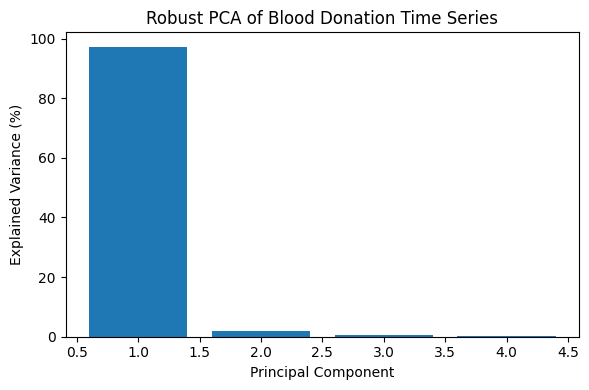


Intraclass Correlation Coefficients (regular):


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.221596,2.138718,7164,21495,0.0,"[0.21, 0.23]"
1,ICC2,Single random raters,0.326249,10.597632,7164,21492,0.0,"[0.05, 0.56]"
2,ICC3,Single fixed raters,0.705831,10.597632,7164,21492,0.0,"[0.7, 0.71]"
3,ICC1k,Average raters absolute,0.532430,2.138718,7164,21495,0.0,"[0.51, 0.55]"
4,ICC2k,Average random raters,0.659506,10.597632,7164,21492,0.0,"[0.18, 0.83]"
5,ICC3k,Average fixed raters,0.905639,10.597632,7164,21492,0.0,"[0.9, 0.91]"



Intraclass Correlation Coefficients (robust):


,Type,Description,ICC,F,df1,df2,pval,CI95%
0,ICC1,Single raters absolute,0.225985,2.167856,7164,21495,0.0,"[0.21, 0.24]"
1,ICC2,Single random raters,0.329507,10.726872,7164,21492,0.0,"[0.05, 0.56]"
2,ICC3,Single fixed raters,0.708601,10.726872,7164,21492,0.0,"[0.7, 0.72]"
3,ICC1k,Average raters absolute,0.538715,2.167856,7164,21495,0.0,"[0.52, 0.56]"
4,ICC2k,Average random raters,0.662818,10.726872,7164,21492,0.0,"[0.18, 0.84]"
5,ICC3k,Average fixed raters,0.906776,10.726872,7164,21492,0.0,"[0.9, 0.91]"



--- Aggregation decision ---
Mean Kendall’s τ: 0.844  (ok ≥ 0.60) -> True
PC1 explained variance: 97.2%  (ok ≥ 90%) -> True
PC1 loadings: same_sign=True, CV(|loadings|)=0.027  (ok ≤ 0.35) -> True
Robust ICC3k: 0.907  (ok ≥ 0.90) -> True

Can aggregate blood types into one index? -> True


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import kendalltau
import pingouin as pg

# Optional import for robust covariance estimation
try:
    from sklearn.covariance import MinCovDet
except Exception:
    MinCovDet = None

# -------------------------------------------------
# Robust helper functions
# -------------------------------------------------
def robust_scale(X: np.ndarray):
    """
    Robust standardization: subtract median and divide by MAD*1.4826.
    Returns X_scaled, medians, mad_scaled.
    """
    med = np.nanmedian(X, axis=0)
    mad = np.nanmedian(np.abs(X - med), axis=0)
    mad_scaled = np.where(mad == 0, 1.0, mad) * 1.4826
    Xs = (X - med) / mad_scaled
    return Xs, med, mad_scaled

def winsorize_series(s: pd.Series, lower=0.01, upper=0.99):
    """
    One-dimensional winsorization: clip extremes at given quantiles.
    """
    lo, hi = s.quantile(lower), s.quantile(upper)
    return s.clip(lo, hi)

def kendall_correlation(df):
    """
    Compute Kendall's tau matrix and p-value matrix.
    """
    tau_matrix = df.corr(method='kendall')
    pval_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
    for c1 in df.columns:
        for c2 in df.columns:
            tau, p = kendalltau(df[c1], df[c2])
            pval_matrix.loc[c1, c2] = p
    return tau_matrix, pval_matrix

# -------------------------------------------------
# Data preparation: pivot by blood_type over time
# df must contain: date, donations, blood_type
# -------------------------------------------------
if not {'date','donations','blood_type'}.issubset(df.columns):
    raise ValueError("Required columns: 'date','donations','blood_type'.")

# Ensure chronological order
df = df.copy()
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

# Pivot: rows = dates, columns = blood types, values = donations
df_all_blood_types = (
    df.pivot_table(index='date', columns='blood_type', values='donations', aggfunc='sum')
      .fillna(0.0)
)

# -------------------------------------------------
# Step 1: Kendall correlations between blood types
# -------------------------------------------------
tau_mat, pval_mat = kendall_correlation(df_all_blood_types)

print("Kendall's tau matrix:")
display(tau_mat)
print("\nP-value matrix:")
display(pval_mat)

# -------------------------------------------------
# Step 2: Robust PCA
# -------------------------------------------------
# Parameters you can tune:
apply_log1p = True        # Apply log(1+x) transform to reduce skew/outlier impact
use_mcd = True            # Use MinCovDet if available; otherwise fall back to standard PCA

X = df_all_blood_types.values.astype(float)

# Log-transform to smooth skew and reduce heavy tails (counts are non-negative)
if apply_log1p:
    X = np.log1p(X)

# Robust scaling (median/MAD)
X_scaled, med, mad_scaled = robust_scale(X)

components = None
explained_var = None
cumulative_var = None
scores = None

if use_mcd and (MinCovDet is not None):
    # Robust covariance estimation
    mcd = MinCovDet(random_state=0).fit(X_scaled)
    cov = mcd.covariance_
    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    # Sort in descending order of eigenvalues
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]
    # Principal components (loadings), explained variance, and scores
    components = eigvecs
    explained_var = eigvals / eigvals.sum()
    cumulative_var = np.cumsum(explained_var)
    scores = X_scaled @ components
else:
    # Fallback to classical PCA if MinCovDet not available
    from sklearn.decomposition import PCA
    pca = PCA()
    scores = pca.fit_transform(X_scaled)
    components = pca.components_.T
    explained_var = pca.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)

# PCA summary
print("\nExplained variance per component:", explained_var)
print("Cumulative explained variance:", cumulative_var)

# Explained variance plot
plt.figure(figsize=(6,4))
plt.bar(range(1, len(explained_var)+1), explained_var * 100)
plt.title("Robust PCA of Blood Donation Time Series")
plt.xlabel("Principal Component")
plt.ylabel("Explained Variance (%)")
plt.tight_layout()
plt.show()

# -------------------------------------------------
# Step 3: ICC – regular vs. robust
# -------------------------------------------------
# Prepare long-format table for ICC
df_icc_raw = df_all_blood_types.reset_index().melt(
    id_vars='date', var_name='blood_type', value_name='donations'
)
df_icc_raw['rater'] = df_icc_raw['blood_type']
df_icc_raw['target'] = df_icc_raw['date'].astype(str)

# Regular ICC
icc_regular = pg.intraclass_corr(
    data=df_icc_raw, targets='target', raters='rater', ratings='donations'
)

# Robust ICC:
# 1) Winsorize within rater
df_rob = df_icc_raw.copy()
df_rob['donations_w'] = (
    df_rob.groupby('rater')['donations']
          .transform(lambda s: winsorize_series(s, 0.01, 0.99))
)

# 2) Robust z-score within rater (median/MAD scaling)
def robust_z_within_rater(s: pd.Series) -> pd.Series:
    med = s.median()
    mad = (s - med).abs().median()
    scale = (mad if mad != 0 else 1.0) * 1.4826
    return (s - med) / scale

df_rob['donations_wz'] = (
    df_rob.groupby('rater')['donations_w']
          .transform(robust_z_within_rater)
)

# 3) Compute ICC on robust-transformed ratings
icc_robust = pg.intraclass_corr(
    data=df_rob.rename(columns={'donations_wz':'donations'}),
    targets='target', raters='rater', ratings='donations'
)

print("\nIntraclass Correlation Coefficients (regular):")
display(icc_regular)

print("\nIntraclass Correlation Coefficients (robust):")
display(icc_robust)
# ---- Decision layer: can we aggregate to a single series? ----

def mean_offdiag(mat: pd.DataFrame) -> float:
    m = mat.values.astype(float)
    n = m.shape[0]
    if n < 2:
        return np.nan
    off = m[~np.eye(n, dtype=bool)]
    return float(np.nanmean(off))

# 1) rank-correlation criterion (Kendall's tau)
tau_mean = mean_offdiag(tau_mat)
tau_ok = (tau_mean >= 0.60)

# 2) dominant common component (PC1)
pc1_var = float(explained_var[0]) if (explained_var is not None and len(explained_var) > 0) else 0.0
pc1_ok = (pc1_var >= 0.90)

# 3) PC1 loadings: same sign & similar magnitude
# components shape: columns are PCs; rows align with df_all_blood_types.columns
pc1_loadings = components[:, 0]
same_sign = np.all(pc1_loadings >= 0) or np.all(pc1_loadings <= 0)
abs_load = np.abs(pc1_loadings)
cv_load = (abs_load.std() / (abs_load.mean() + 1e-12)) if abs_load.mean() > 0 else np.inf
loadings_ok = same_sign and (cv_load <= 0.35)

# 4) robust ICC3k ≥ 0.90
def extract_icc3k(table: pd.DataFrame) -> float | None:
    t = table[table['Type'].str.upper() == 'ICC3K']
    return float(t['ICC'].iloc[0]) if len(t) else None

icc3k_rob = extract_icc3k(icc_robust)
icc_ok = (icc3k_rob is not None) and (icc3k_rob >= 0.90)

can_aggregate = tau_ok and pc1_ok and loadings_ok and icc_ok

print("\n--- Aggregation decision ---")
print(f"Mean Kendall’s τ: {tau_mean:.3f}  (ok ≥ 0.60) -> {tau_ok}")
print(f"PC1 explained variance: {pc1_var*100:.1f}%  (ok ≥ 90%) -> {pc1_ok}")
print(f"PC1 loadings: same_sign={same_sign}, CV(|loadings|)={cv_load:.3f}  (ok ≤ 0.35) -> {loadings_ok}")
print(f"Robust ICC3k: {None if icc3k_rob is None else round(icc3k_rob,3)}  (ok ≥ 0.90) -> {icc_ok}")
print(f"\nCan aggregate blood types into one index? -> {can_aggregate}")


### בדיקת נורמליות

In [ ]:
import pandas as pd
from scipy.stats import shapiro, anderson
import warnings

# Ensure 'date' is datetime and create 'month'
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month

# --- Normality Test Function ---
def check_normality(data):
    """
    Performs Shapiro-Wilk and Anderson-Darling tests if sample size and variance are sufficient.
    Returns a dictionary with test results.
    """
    shapiro_p = None
    shapiro_normal = None
    anderson_stat = None
    anderson_normal = None

    # Check for sufficient sample size for Shapiro-Wilk (N >= 3)
    if len(data) >= 3:
        # Suppress UserWarning for zero variance in shapiro
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                shapiro_stat, shapiro_p = shapiro(data)
                shapiro_normal = shapiro_p > 0.05
            except ValueError: # Handle cases where shapiro might still fail
                pass # Keep results as None

    # Check for sufficient sample size for Anderson-Darling (N > 7) and non-zero variance
    if len(data) > 7 and data.std() > 1e-9:
         # Suppress UserWarning for zero variance in anderson
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                result = anderson(data)
                anderson_stat = result.statistic
                # Check against 5% significance level
                anderson_normal = anderson_stat < result.critical_values[2]
            except ValueError: # Handle cases where anderson might still fail
                pass # Keep results as None


    return {
        'Shapiro_p': shapiro_p,
        'Shapiro_Normal': shapiro_normal,
        'Anderson_stat': anderson_stat,
        'Anderson_Normal': anderson_normal
    }

# --- Normality by State and Month ---
results_state_month = []

for state, state_group in df.groupby('state'):
    for month, month_group in state_group.groupby('month'):
        donations = month_group['donations'].values
        normality_results = check_normality(donations)
        results_state_month.append({
            'state': state,
            'month': str(month),
            **normality_results
        })

df_results_state_month = pd.DataFrame(results_state_month)

# --- Normality National by Month ---
results_national = []

for month, group in df.groupby('month'):
    donations = group['donations'].values
    normality_results = check_normality(donations)
    results_national.append({
        'state': 'National', # Label for national level
        'month': str(month),
        **normality_results
    })

df_results_national = pd.DataFrame(results_national)

# --- Combine and Display Results ---
final_results = pd.concat([df_results_state_month, df_results_national], ignore_index=True)

# Sort for better readability (optional)
final_results = final_results.sort_values(by=['state', 'month'])

display(final_results)

,state,month,Shapiro_p,Shapiro_Normal,Anderson_stat,Anderson_Normal
0,Johor,1,2.102775e-46,False,130.005498,False
9,Johor,10,4.361799e-46,False,127.111725,False
10,Johor,11,3.330439e-46,False,132.797802,False
11,Johor,12,5.417708e-48,False,146.751681,False
1,Johor,2,4.196927e-44,False,110.477819,False
...,...,...,...,...,...,...
148,W.P. Kuala Lumpur,5,2.363692e-38,False,65.711229,False
149,W.P. Kuala Lumpur,6,1.418570e-34,False,47.127477,False
150,W.P. Kuala Lumpur,7,4.394064e-35,False,51.045975,False
151,W.P. Kuala Lumpur,8,3.378758e-34,False,47.650660,False


In [ ]:
# Check if any entries in final_results show normality
shapiro_normal_count = final_results['Shapiro_Normal'].sum()
anderson_normal_count = final_results['Anderson_Normal'].sum()

print(f"Number of entries where Shapiro-Wilk indicates normality: {shapiro_normal_count}")
print(f"Number of entries where Anderson-Darling indicates normality: {anderson_normal_count}")

Number of entries where Shapiro-Wilk indicates normality: 0
Number of entries where Anderson-Darling indicates normality: 0


In [ ]:
import pandas as pd
from scipy.stats import shapiro, anderson
import warnings

# Ensure 'date' is datetime and create 'dayofweek'
df['date'] = pd.to_datetime(df['date'])
df['dayofweek'] = df['date'].dt.day_name()

# --- Normality Test Function ---
def check_normality(data):
    """
    Performs Shapiro-Wilk and Anderson-Darling tests if sample size and variance are sufficient.
    Returns a dictionary with test results.
    """
    shapiro_p = None
    shapiro_normal = None
    anderson_stat = None
    anderson_normal = None

    # Check for sufficient sample size for Shapiro-Wilk (N >= 3)
    if len(data) >= 3:
        # Suppress UserWarning for zero variance in shapiro
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                shapiro_stat, shapiro_p = shapiro(data)
                shapiro_normal = shapiro_p > 0.05
            except ValueError: # Handle cases where shapiro might still fail
                pass # Keep results as None

    # Check for sufficient sample size for Anderson-Darling (N > 7) and non-zero variance
    if len(data) > 7 and data.std() > 1e-9:
         # Suppress UserWarning for zero variance in anderson
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                result = anderson(data)
                anderson_stat = result.statistic
                # Check against 5% significance level
                anderson_normal = anderson_stat < result.critical_values[2]
            except ValueError: # Handle cases where anderson might still fail
                pass # Keep results as None


    return {
        'Shapiro_p': shapiro_p,
        'Shapiro_Normal': shapiro_normal,
        'Anderson_stat': anderson_stat,
        'Anderson_Normal': anderson_normal
    }

# --- Normality by State and Day of Week ---
results_state_dayofweek = []

for state, state_group in df.groupby('state'):
    for day, day_group in state_group.groupby('dayofweek'):
        donations = day_group['donations'].values
        normality_results = check_normality(donations)
        results_state_dayofweek.append({
            'state': state,
            'dayofweek': day,
            **normality_results
        })

df_results_state_dayofweek = pd.DataFrame(results_state_dayofweek)

# --- Normality National by Day of Week ---
results_national_dayofweek = []

for day, group in df.groupby('dayofweek'):
    donations = group['donations'].values
    normality_results = check_normality(donations)
    results_national_dayofweek.append({
        'state': 'National', # Label for national level
        'dayofweek': day,
        **normality_results
    })

df_results_national_dayofweek = pd.DataFrame(results_national_dayofweek)

# --- Combine and Display Results ---
final_results_dayofweek = pd.concat([df_results_state_dayofweek, df_results_national_dayofweek], ignore_index=True)

# Sort for better readability
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
final_results_dayofweek['dayofweek'] = pd.Categorical(final_results_dayofweek['dayofweek'], categories=day_order, ordered=True)
final_results_dayofweek = final_results_dayofweek.sort_values(['state', 'dayofweek'])

display(final_results_dayofweek)

,state,dayofweek,Shapiro_p,Shapiro_Normal,Anderson_stat,Anderson_Normal
1,Johor,Monday,5.014992e-54,False,191.844981,False
5,Johor,Tuesday,2.361890e-50,False,138.917446,False
6,Johor,Wednesday,2.893039e-49,False,134.130214,False
4,Johor,Thursday,1.845750e-49,False,131.458066,False
0,Johor,Friday,1.377834e-68,False,419.729307,False
...,...,...,...,...,...,...
90,W.P. Kuala Lumpur,Wednesday,1.727828e-36,False,50.341996,False
88,W.P. Kuala Lumpur,Thursday,3.736697e-36,False,49.341045,False
84,W.P. Kuala Lumpur,Friday,9.393571e-42,False,61.398975,False
86,W.P. Kuala Lumpur,Saturday,2.622146e-38,False,59.469976,False


In [ ]:
# Check if any entries in final_results_dayofweek show normality
shapiro_normal_count_dayofweek = final_results_dayofweek['Shapiro_Normal'].sum()
anderson_normal_count_dayofweek = final_results_dayofweek['Anderson_Normal'].sum()

print(f"Number of entries where Shapiro-Wilk indicates normality (by day of week): {shapiro_normal_count_dayofweek}")
print(f"Number of entries where Anderson-Darling indicates normality (by day of week): {anderson_normal_count_dayofweek}")

Number of entries where Shapiro-Wilk indicates normality (by day of week): 0
Number of entries where Anderson-Darling indicates normality (by day of week): 0


### 📊 Q-Q Plots לכל חודשי השנה (בדיקת נורמליות חזותית)

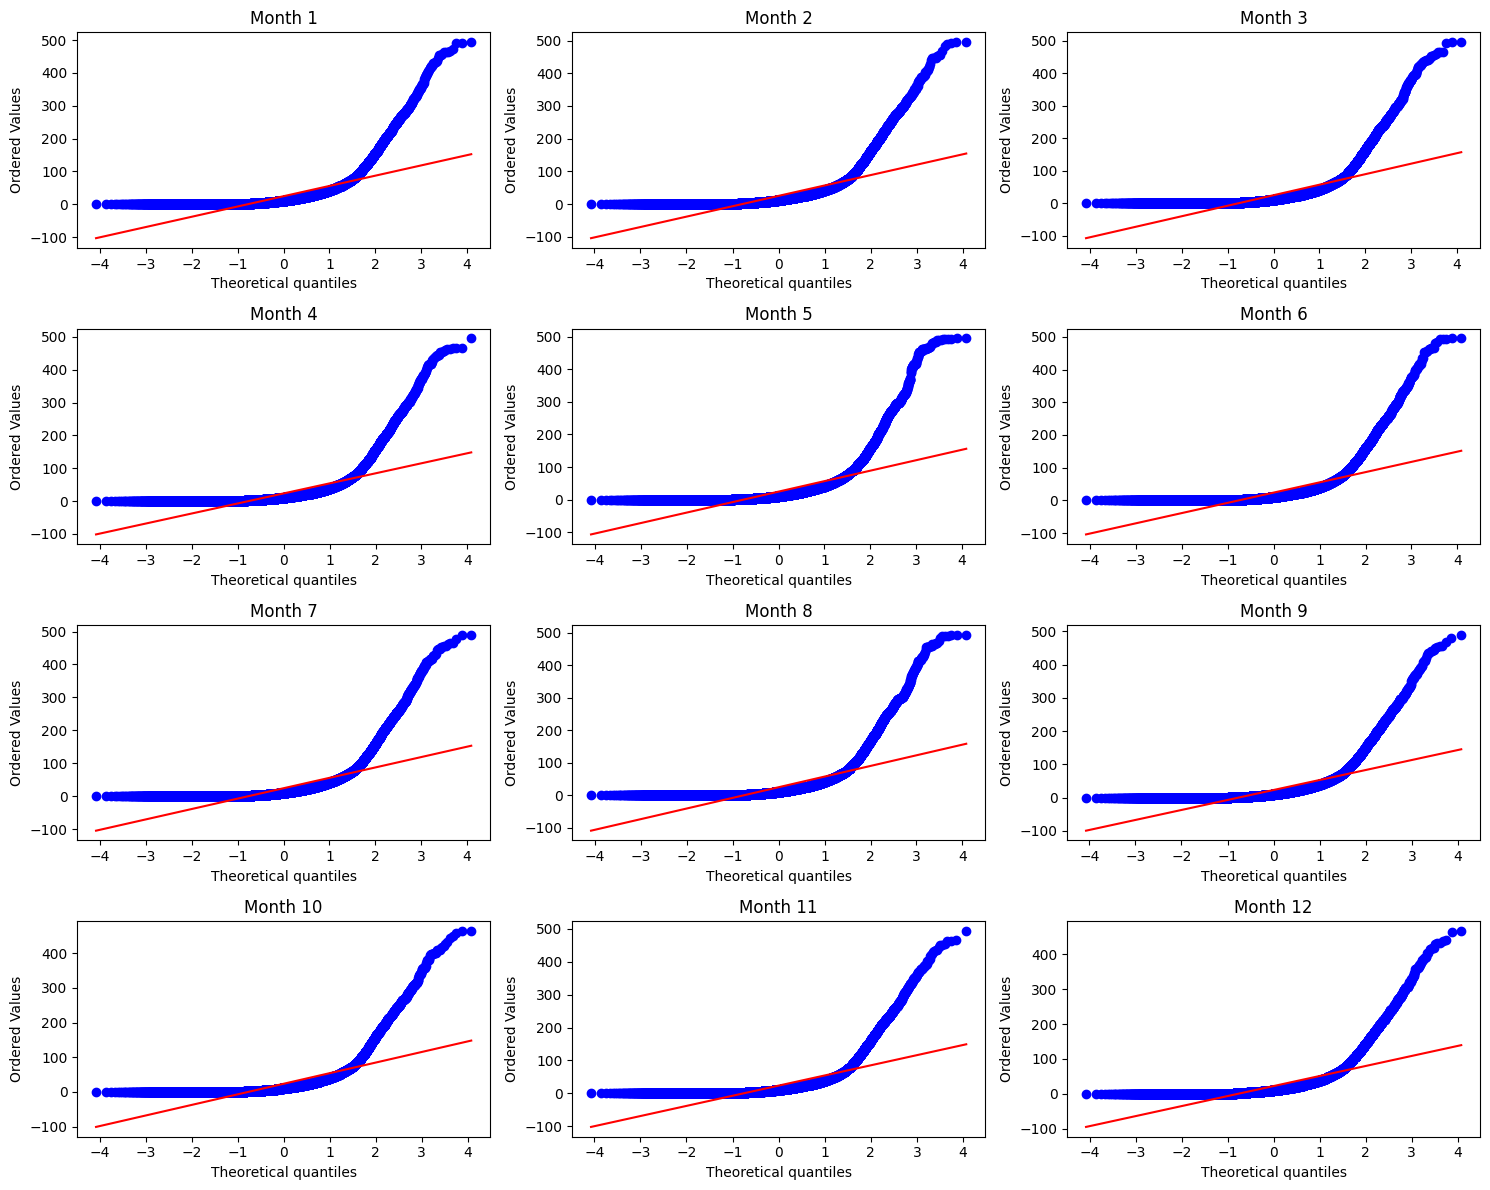

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

# Create Q-Q Plots for all months
months = df['month'].sort_values().unique()

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 12))
axes = axes.flatten()

for i, month in enumerate(months):
    month_data = df[df['month'] == month]['donations']
    stats.probplot(month_data, dist="norm", plot=axes[i])
    axes[i].set_title(f"Month {month}")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Load the data
URL_DATA = 'https://storage.dosm.gov.my/population/population_malaysia.parquet'
data = pd.read_parquet(URL_DATA)

# Ensure 'date' is in datetime format
if 'date' in df.columns:
    data['date'] = pd.to_datetime(data['date'])

# Preview columns to identify the population column
print(data.columns)
# Replace 'population' with the correct column name if different
population_column = 'population'  # change if needed

# Filter for years 2006–2025
data['year'] = data['date'].dt.year
filtered_df = data[(data['year'] >= 2006) & (data['year'] <= 2024)]
filtered_df = filtered_df[(filtered_df['age'] == 'overall') & (filtered_df['sex'] == 'both') & (filtered_df['ethnicity'] == 'overall')]
print(filtered_df.head())

# Aggregate population by year
annual_population = filtered_df.groupby('year')[population_column].sum()*100 #The data is given in hundreds.

# Display the result
print(annual_population)

Index(['date', 'sex', 'age', 'ethnicity', 'population'], dtype='object')
            date   sex      age ethnicity  population  year
9435  2006-01-01  both  overall   overall     26549.9  2006
9834  2007-01-01  both  overall   overall     27058.4  2007
10233 2008-01-01  both  overall   overall     27567.6  2008
10632 2009-01-01  both  overall   overall     28081.5  2009
11031 2010-01-01  both  overall   overall     28588.6  2010
year
2006    2654990.0
2007    2705840.0
2008    2756760.0
2009    2808150.0
2010    2858860.0
2011    2906200.0
2012    2951000.0
2013    3021370.0
2014    3070850.0
2015    3118610.0
2016    3163350.0
2017    3202260.0
2018    3238230.0
2019    3252300.0
2020    3244740.0
2021    3257630.0
2022    3269810.0
2023    3340180.0
2024    3405210.0
Name: population, dtype: float64


In [ ]:
import pymannkendall as mk

annual = df.groupby('year')['donations'].sum()/annual_population
print(annual)
results = mk.original_test(annual)

print(results)

year
2006    0.164890
2007    0.206498
2008    0.252735
2009    0.274400
2010    0.275046
2011    0.286799
2012    0.287849
2013    0.291192
2014    0.317698
2015    0.343626
2016    0.337164
2017    0.330466
2018    0.349017
2019    0.344845
2020    0.306702
2021    0.306822
2022    0.342413
2023    0.344526
2024    0.344929
2025         NaN
dtype: float64
Mann_Kendall_Test(trend='increasing', h=np.True_, p=np.float64(1.0424193296776352e-05), z=np.float64(4.408181999810314), Tau=np.float64(0.7426900584795322), s=np.float64(127.0), var_s=817.0, slope=np.float64(0.007166046227219433), intercept=np.float64(0.24232802849292534))


In [ ]:
from scipy.stats import shapiro, anderson
import pandas as pd

# Assuming 'annual' Series is available from previous steps
# Based on the notebook state, 'annual' is a Series with year as index and donation rate as value.

# Check if 'annual' is empty or has enough data for the tests
# Shapiro-Wilk requires at least 3 samples
# Anderson-Darling usually recommended for N > 7 or 8
data_for_normality = annual.dropna().values

if len(data_for_normality) >= 3:
    # Perform Shapiro-Wilk test
    shapiro_stat, shapiro_p_value = shapiro(data_for_normality)

    print(f"Shapiro-Wilk Test for Annual Donation Rate per Capita:")
    print(f"Test Statistic: {shapiro_stat:.4f}")
    print(f"P-value: {shapiro_p_value:.4f}")

    # Interpret Shapiro-Wilk result
    alpha = 0.05
    if shapiro_p_value > alpha:
        print(f"Result: The data appears to be normally distributed according to Shapiro-Wilk (p > {alpha}).")
    else:
        print(f"Result: The data does not appear to be normally distributed according to Shapiro-Wilk (p <= {alpha}).")
    print("-" * 30)

if len(data_for_normality) > 7:
    # Perform Anderson-Darling test
    try:
        anderson_result = anderson(data_for_normality)

        print(f"Anderson-Darling Test for Annual Donation Rate per Capita:")
        print(f"Test Statistic: {anderson_result.statistic:.4f}")
        print("Critical Values and Significance Levels:")
        for i in range(len(anderson_result.critical_values)):
            sig_level = anderson_result.significance_level[i]
            crit_value = anderson_result.critical_values[i]
            print(f"  {sig_level}%: {crit_value:.4f}")

        # Interpret Anderson-Darling result (commonly using the 5% significance level)
        if anderson_result.statistic < anderson_result.critical_values[2]: # Index 2 is for 5% significance level
             print(f"Result: The data appears to be normally distributed according to Anderson-Darling at the 5% significance level (stat < critical value).")
        else:
             print(f"Result: The data does not appear to be normally distributed according to Anderson-Darling at the 5% significance level (stat >= critical value).")

    except ValueError:
        print("Could not perform Anderson-Darling test (e.g., due to zero variance).")

else:
    print("Not enough data points (at least 3 for Shapiro-Wilk, >7 for Anderson-Darling) for normality tests on annual data.")

Shapiro-Wilk Test for Annual Donation Rate per Capita:
Test Statistic: 0.8482
P-value: 0.0063
Result: The data does not appear to be normally distributed according to Shapiro-Wilk (p <= 0.05).
------------------------------
Anderson-Darling Test for Annual Donation Rate per Capita:
Test Statistic: 0.9245
Critical Values and Significance Levels:
  15.0%: 0.5050
  10.0%: 0.5750
  5.0%: 0.6900
  2.5%: 0.8040
  1.0%: 0.9570
Result: The data does not appear to be normally distributed according to Anderson-Darling at the 5% significance level (stat >= critical value).


In [ ]:
import pandas as pd
from scipy.stats import shapiro, anderson
import warnings
import numpy as np

# Assuming df is already loaded and includes 'state', 'year', and 'donations'
# Ensure 'year' column is available, assuming it was created from 'date'

# --- Load State Population Data ---
URL_POP = 'https://storage.dosm.gov.my/population/population_state.parquet'
population = pd.read_parquet(URL_POP)
population['date'] = pd.to_datetime(population['date'])
population['year'] = population['date'].dt.year

# --- Filter Population Data as specified by the user ---
filtered_population_df = population[(population['year'] >= 2006) & (population['year'] <= 2024)].copy() # Use .copy() to avoid SettingWithCopyWarning
filtered_population_df = filtered_population_df[(filtered_population_df['age'] == 'overall') & (filtered_population_df['sex'] == 'both') & (filtered_population_df['ethnicity'] == 'overall')].copy() # Use .copy()

# Aggregate filtered population by state and year
population_state_year = filtered_population_df.groupby(['state', 'year'])['population'].sum().reset_index()

# --- Merge Donations with Population Data and Calculate Per Capita ---
# Aggregate donations by state and year first
annual_donations_state = df.groupby(['state', 'year'])['donations'].sum().reset_index()

# Merge annual donations with filtered population_state_year
df_annual_merged = pd.merge(annual_donations_state, population_state_year, on=['state', 'year'], how='left')

# Calculate annual donations per capita by state
df_annual_merged['donations_per_capita_annual'] = df_annual_merged.apply(
    lambda row: row['donations'] / row['population'] if row['population'] > 0 and pd.notna(row['population']) else np.nan,
    axis=1
)

# Drop rows with NaN per capita values (likely due to missing population data for certain years/states)
df_annual_merged = df_annual_merged.dropna(subset=['donations_per_capita_annual'])


# --- Normality Test Function (reused) ---
def check_normality(data):
    """
    Performs Shapiro-Wilk and Anderson-Darling tests if sample size and variance are sufficient.
    Returns a dictionary with test results.
    """
    shapiro_p = None
    shapiro_normal = None
    anderson_stat = None
    anderson_normal = None

    # Check for sufficient sample size for Shapiro-Wilk (N >= 3)
    if len(data) >= 3:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                shapiro_stat, shapiro_p = shapiro(data)
                shapiro_normal = shapiro_p > 0.05
            except ValueError:
                pass

    # Check for sufficient sample size for Anderson-Darling (N > 7) and non-zero variance
    if len(data) > 7 and data.std() > 1e-9:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                result = anderson(data)
                anderson_stat = result.statistic
                anderson_normal = anderson_stat < result.critical_values[2]
            except ValueError:
                pass

    return {
        'Shapiro_p': shapiro_p,
        'Shapiro_Normal': shapiro_normal,
        'Anderson_stat': anderson_stat,
        'Anderson_Normal': anderson_normal
    }

# --- Perform Normality Test per State on Annual Per Capita Data ---
normality_results_state_annual = []

for state, state_group in df_annual_merged.groupby('state'):
    annual_per_capita_data = state_group['donations_per_capita_annual'].values
    normality_results = check_normality(annual_per_capita_data)
    normality_results_state_annual.append({
        'state': state,
        'sample_size (years)': len(annual_per_capita_data),
        **normality_results
    })

df_normality_results_state_annual = pd.DataFrame(normality_results_state_annual)

# --- Display Results ---
display(df_normality_results_state_annual)

,state,sample_size (years),Shapiro_p,Shapiro_Normal,Anderson_stat,Anderson_Normal
0,Johor,19,0.000032,False,2.674253,False
1,Kedah,19,0.002632,False,1.261107,False
2,Kelantan,19,0.012203,False,0.810796,False
3,Melaka,19,0.000002,False,2.812964,False
4,Negeri Sembilan,19,0.000015,False,2.128183,False
5,Pahang,19,0.014083,False,0.844081,False
6,Perak,19,0.000161,False,1.828641,False
7,Pulau Pinang,19,0.000089,False,2.377553,False
8,Sabah,19,0.142586,True,0.581005,True
9,Sarawak,19,0.036504,False,0.804252,False


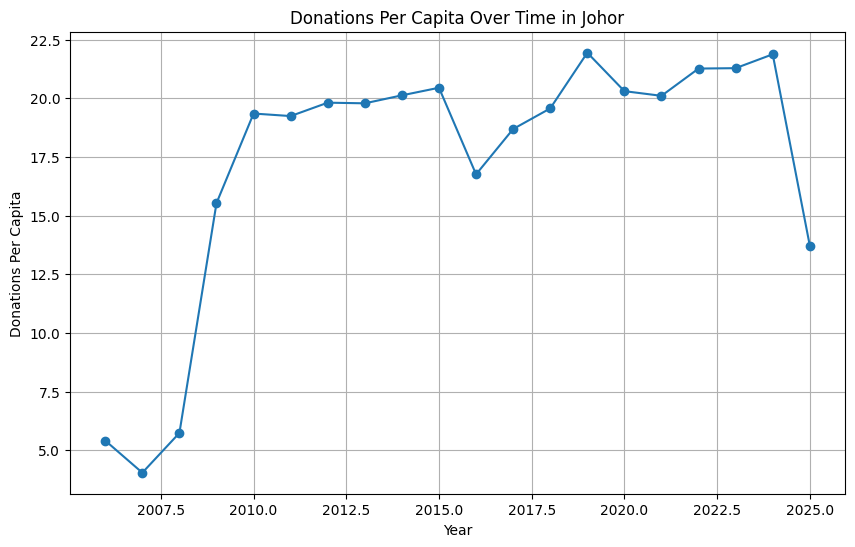

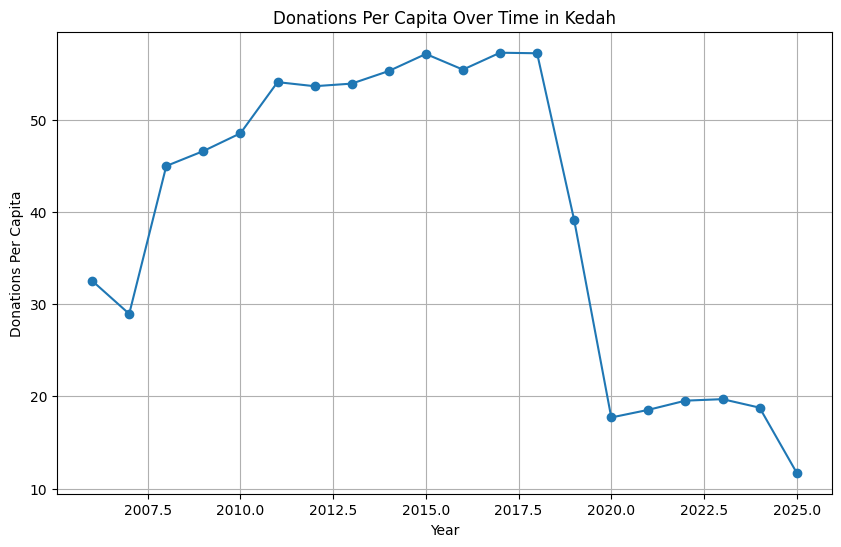

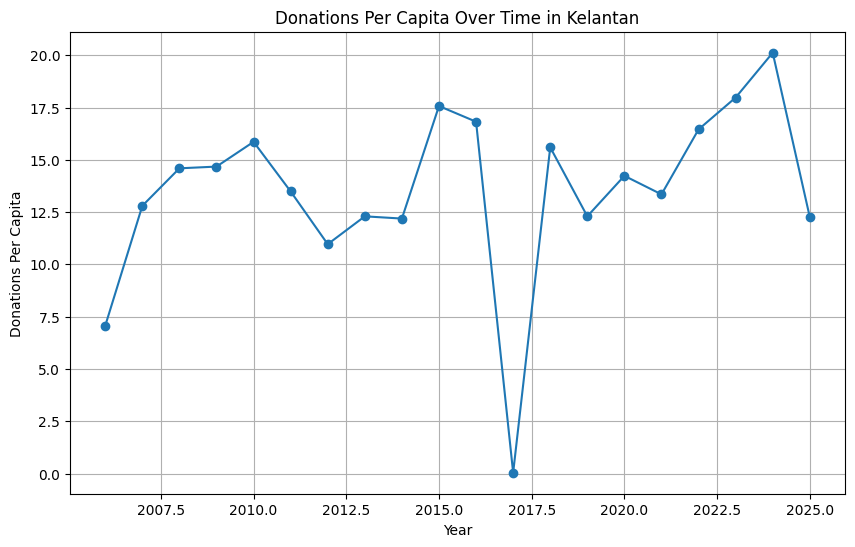

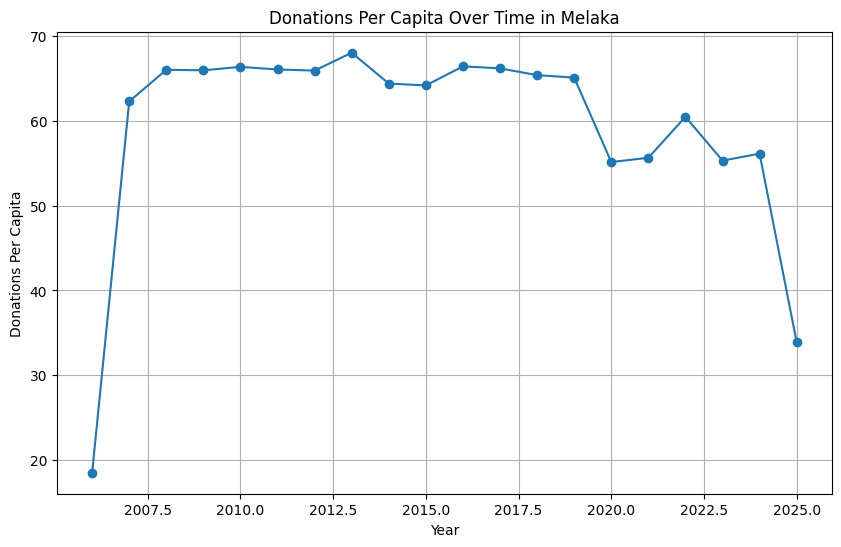

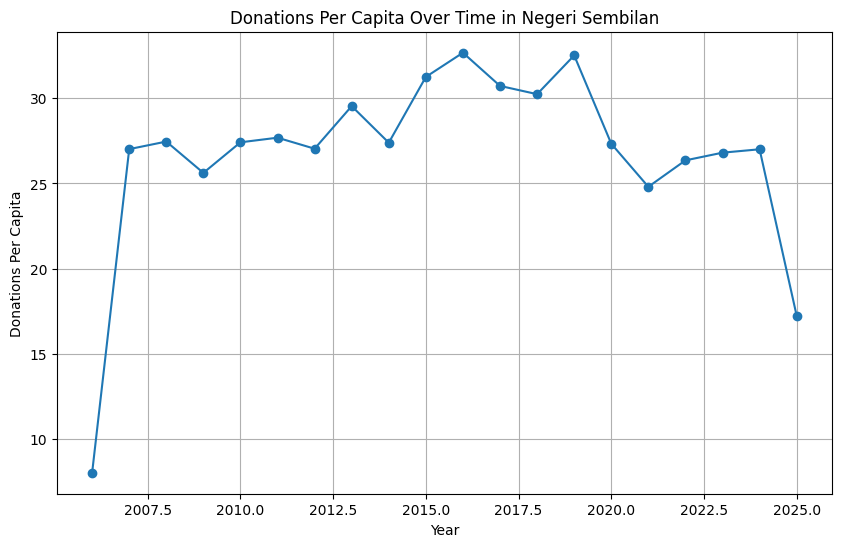

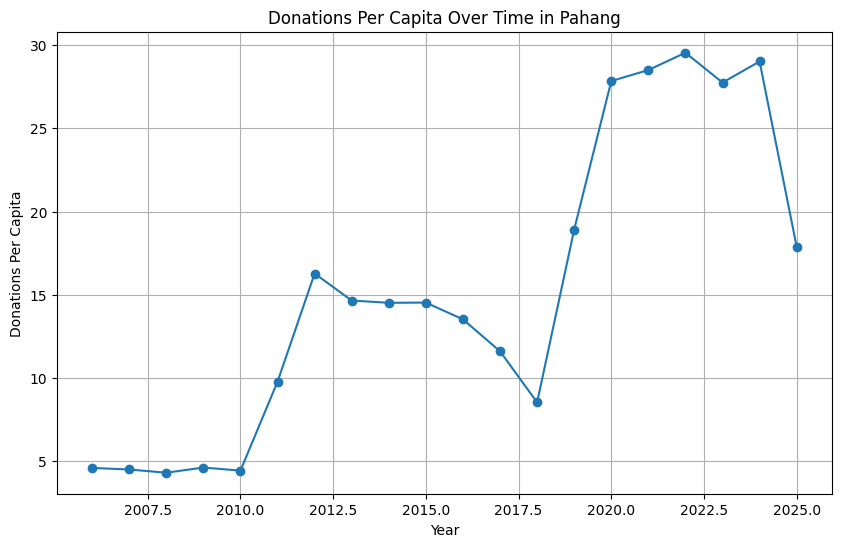

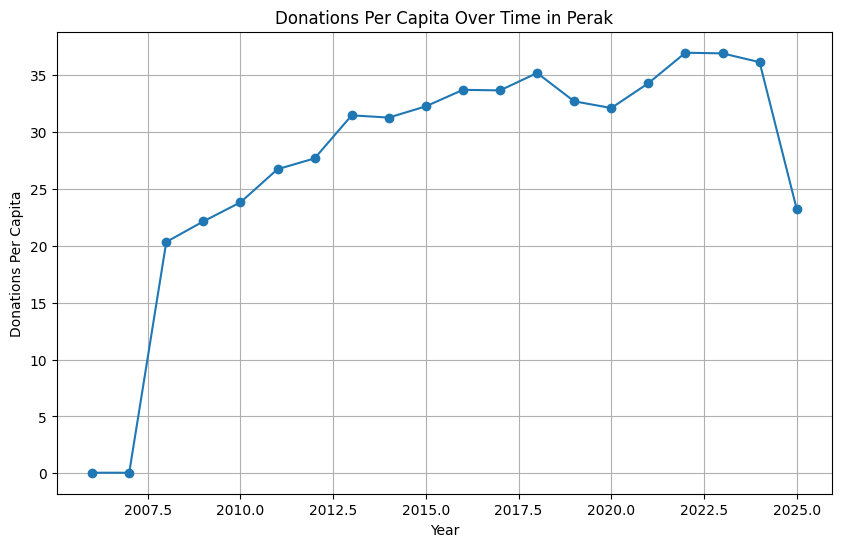

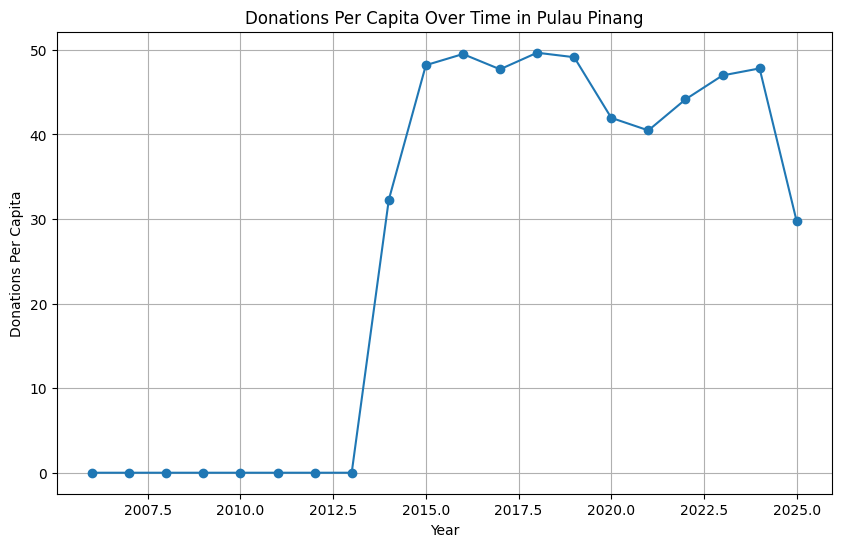

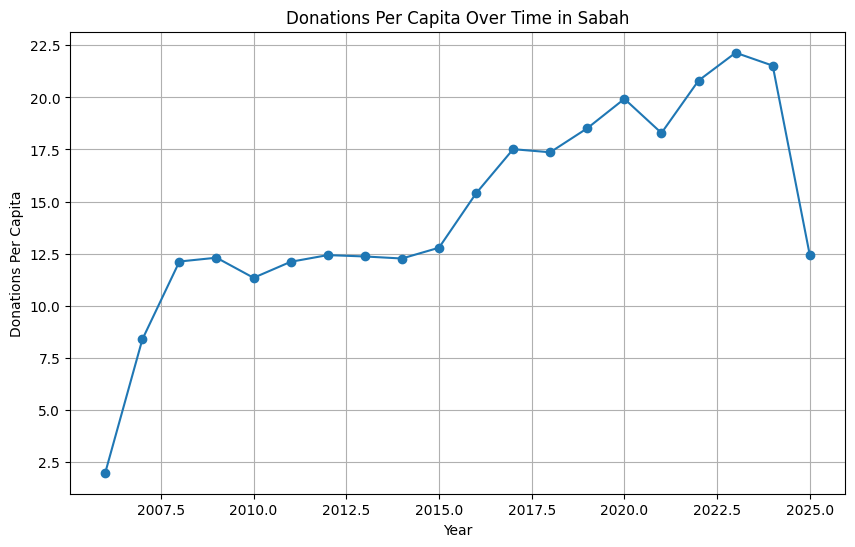

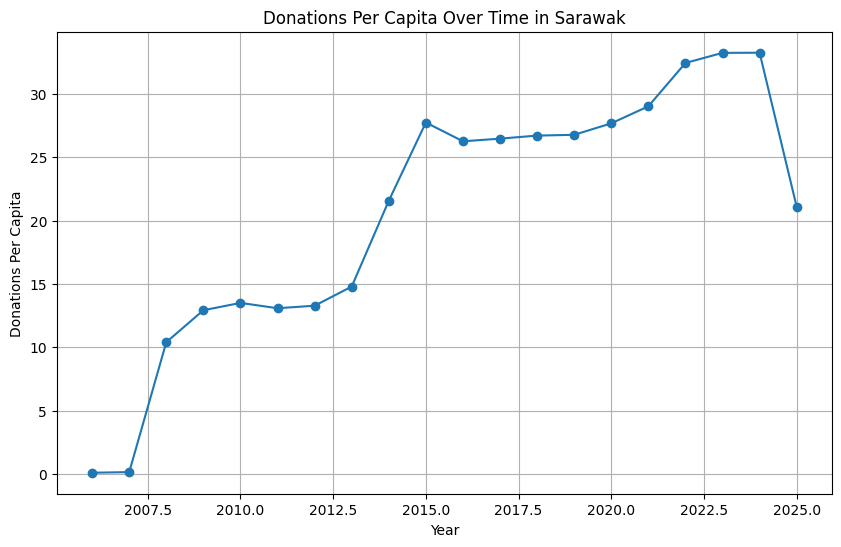

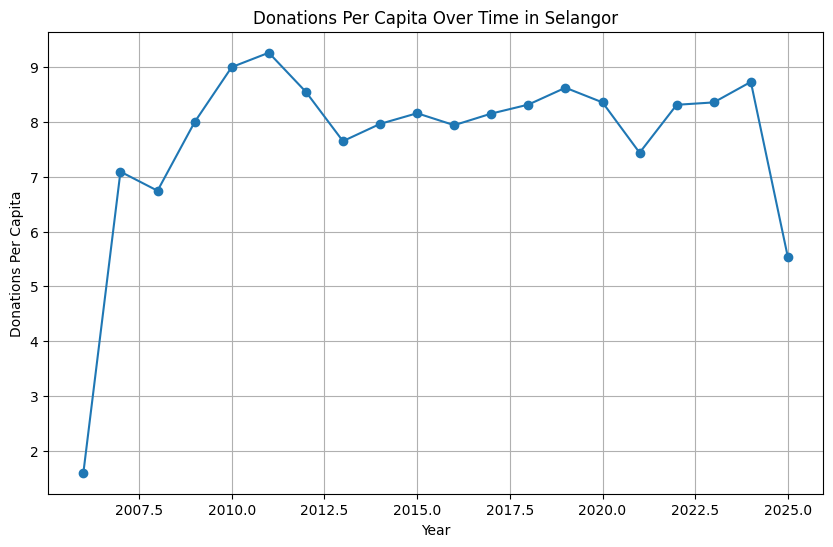

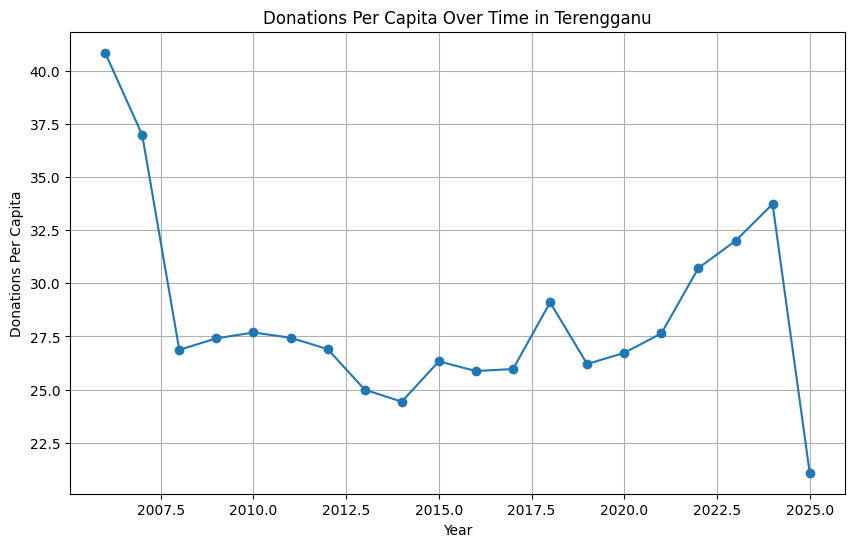

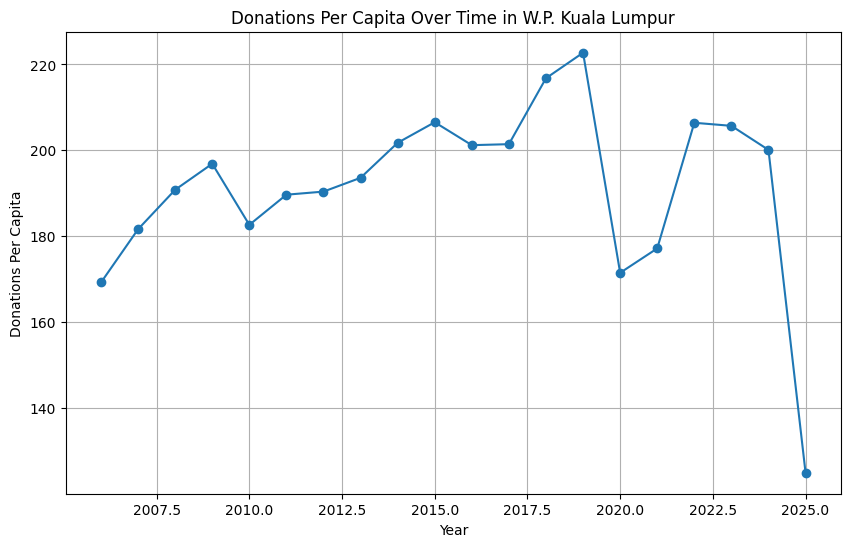

In [ ]:
# Combine donations data with population data
# First, aggregate donations by state and year
df_state_year = df.groupby(['state', 'year'])['donations'].sum().reset_index()

# Load state-level population data
URL_POPULATION_STATE = 'https://storage.dosm.gov.my/population/population_state.parquet'
df_population_state = pd.read_parquet(URL_POPULATION_STATE)

# Preprocess state-level population data
df_population_state['date'] = pd.to_datetime(df_population_state['date'])
df_population_state['year'] = df_population_state['date'].dt.year
# Filter population data for relevant columns and criteria (overall age, sex, ethnicity)
# Note: 'state' column is present in this dataset
df_population_state_filtered = df_population_state[(df_population_state['age'] == 'overall') &
                                      (df_population_state['sex'] == 'both') &
                                      (df_population_state['ethnicity'] == 'overall')]

# Aggregate population by state and year
df_population_state_year = df_population_state_filtered.groupby(['state', 'year'])['population'].sum().reset_index()

# Merge donations and population dataframes
# Using an outer merge to keep all donation data, and fill missing population with 0 for states with no data
df_merged = pd.merge(df_state_year, df_population_state_year, on=['state', 'year'], how='left')

# Calculate donations per capita, handling potential division by zero
df_merged['donations_per_capita'] = df_merged.apply(
    lambda row: row['donations'] / row['population'] if row['population'] > 0 else 0,
    axis=1
)

# Get unique states for plotting
states = df_merged['state'].unique()

# Plot donations per capita for each state over the years
for state in states:
    state_data = df_merged[df_merged['state'] == state]
    # Ensure there is data for the state before plotting
    if not state_data.empty:
        plt.figure(figsize=(10, 6))
        plt.plot(state_data['year'], state_data['donations_per_capita'], marker='o')
        plt.title(f'Donations Per Capita Over Time in {state}')
        plt.xlabel('Year')
        plt.ylabel('Donations Per Capita')
        plt.grid(True)
        plt.show()

In [ ]:
# Kruskal-Wallis test by month
groups = [group['donations'].values for name, group in df.groupby('month')]
kruskal_stat, kruskal_p = kruskal(*groups)
kruskal_stat, kruskal_p

(np.float64(194.2010278013112), np.float64(1.1852446360220391e-35))

In [ ]:
es = pg.kruskal(data=df, dv='donations', between='month')
print(es.columns)

Index(['Source', 'ddof1', 'H', 'p-unc'], dtype='object')


In [ ]:
import scikit_posthocs as sp
dunn_result = sp.posthoc_dunn(df, val_col='donations', group_col='month', p_adjust='bonferroni')
print(dunn_result)

              1             2             3             4             5   \
1   1.000000e+00  2.032053e-01  1.000000e+00  4.518723e-06  2.097758e-02   
2   2.032053e-01  1.000000e+00  1.000000e+00  1.497084e-14  6.236300e-09   
3   1.000000e+00  1.000000e+00  1.000000e+00  1.666630e-11  2.011545e-06   
4   4.518723e-06  1.497084e-14  1.666630e-11  1.000000e+00  1.000000e+00   
5   2.097758e-02  6.236300e-09  2.011545e-06  1.000000e+00  1.000000e+00   
6   4.022076e-08  1.763202e-17  3.330284e-14  1.000000e+00  5.849395e-01   
7   1.000000e+00  2.527787e-04  1.806794e-02  1.375683e-02  1.000000e+00   
8   1.000000e+00  3.997097e-05  3.789825e-03  7.003086e-02  1.000000e+00   
9   9.184814e-09  3.065229e-18  6.106498e-15  1.000000e+00  2.518863e-01   
10  1.368209e-01  1.971090e-07  3.925371e-05  1.000000e+00  1.000000e+00   
11  1.000000e+00  2.975239e-05  2.809329e-03  1.260756e-01  1.000000e+00   
12  5.549485e-04  2.272822e-11  1.265074e-08  1.000000e+00  1.000000e+00   

           

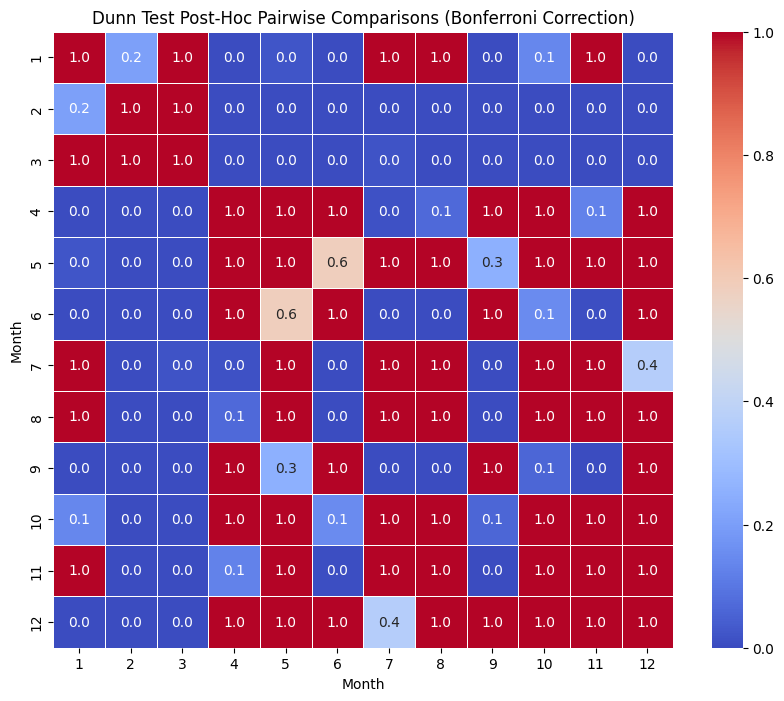

In [ ]:
# Generate heatmap for Dunn test results
plt.figure(figsize=(10, 8))
sns.heatmap(dunn_result, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Dunn Test Post-Hoc Pairwise Comparisons (Bonferroni Correction)')
plt.xlabel('Month')
plt.ylabel('Month')
plt.show()

In [ ]:
import pandas as pd
import pingouin as pg

# Calculate Kruskal-Wallis effect size (epsilon squared)
es = pg.kruskal(data=df, dv='donations', between='month')
n = len(df)
kruskal_h = es['H'][0]
epsilon_sq = kruskal_h / (n - 1)
print(f"Effect size (ε²): {epsilon_sq:.3f}")

Effect size (ε²): 0.000


/tmp/ipython-input-3866503903.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kruskal_h = es['H'][0]


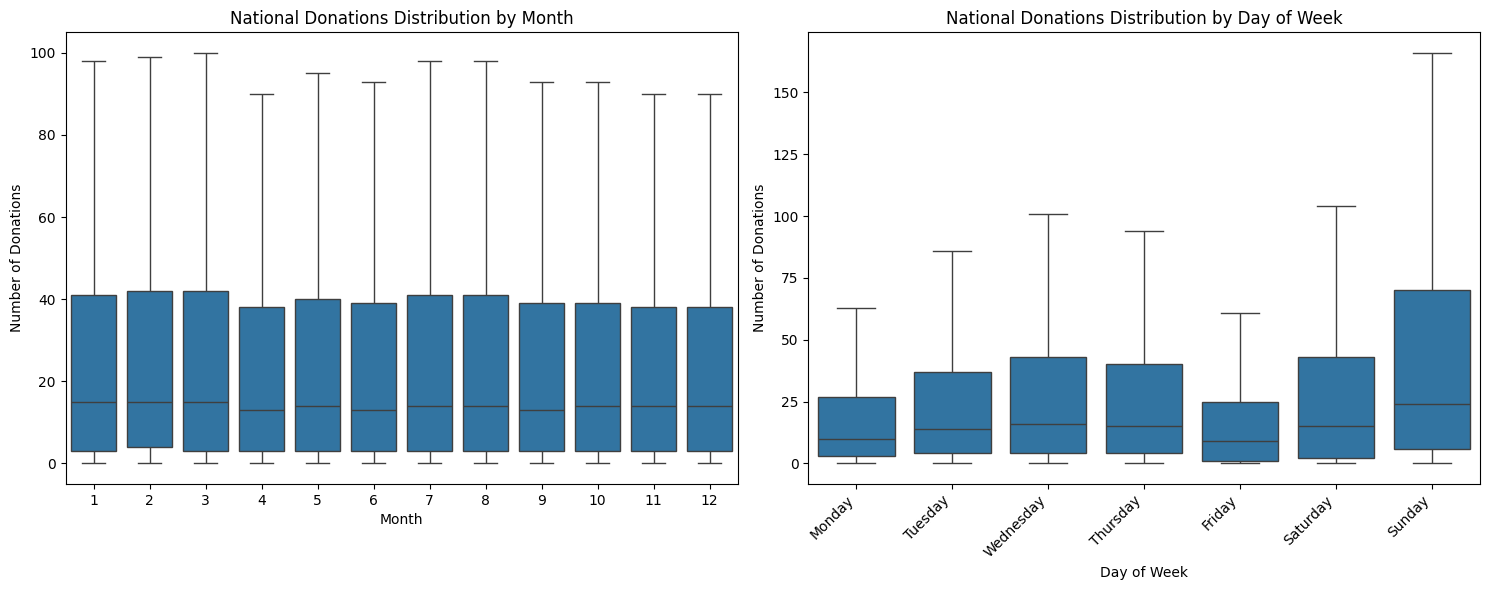

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df is already loaded and preprocessed
# (e.g., date column is datetime, month and dayofweek columns exist)

# --- Create Subplots ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6)) # 1 row, 2 columns

# --- Plot 1: National Donations Distribution by Month ---
# Use the original df and let seaborn group by month
sns.boxplot(x='month', y='donations', data=df, ax=axes[0], whis=1.5,showfliers=False) # whis=1.5 (default)
axes[0].set_title('National Donations Distribution by Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Donations')


# --- Plot 2: National Donations Distribution by Day of Week ---
# Use the original df and let seaborn group by dayofweek
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.boxplot(x='dayofweek', y='donations', data=df, order=day_order, ax=axes[1], whis=1.5,showfliers=False) # whis=1.5 (default)
axes[1].set_title('National Donations Distribution by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Number of Donations')
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for readability


plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

In [ ]:
# Mann-Kendall test using Kendall Tau
annual = df.groupby('year')['donations'].sum().reset_index()
kendalltau(annual['year'], annual['donations'])


SignificanceResult(statistic=np.float64(0.6631578947368422), pvalue=np.float64(1.1598461044767754e-05))

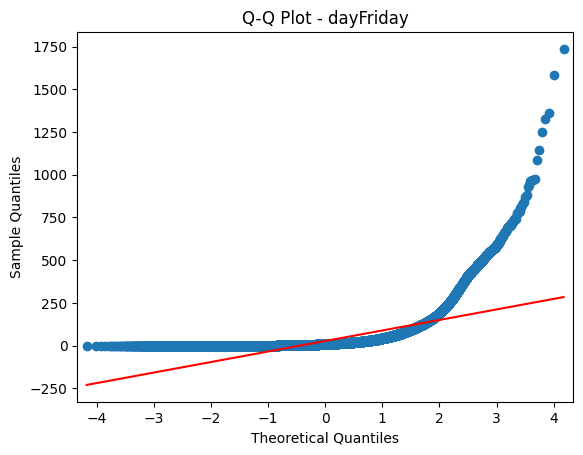

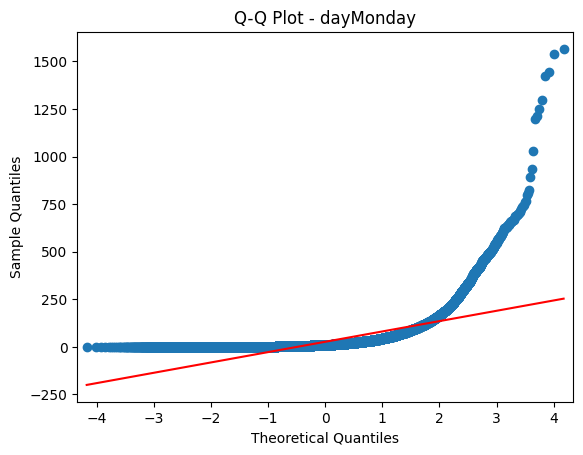

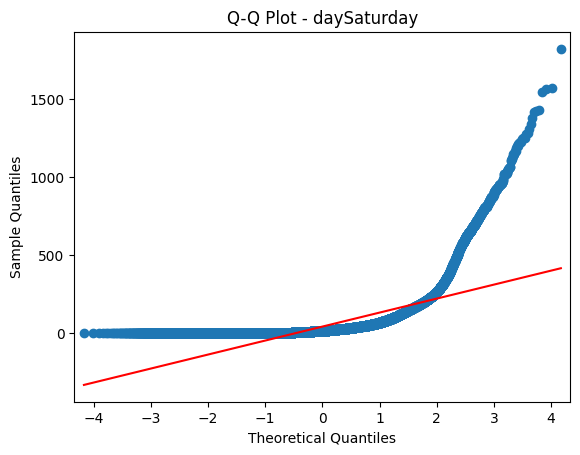

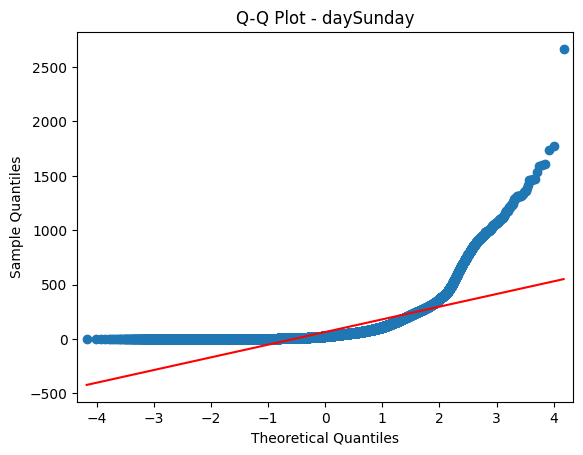

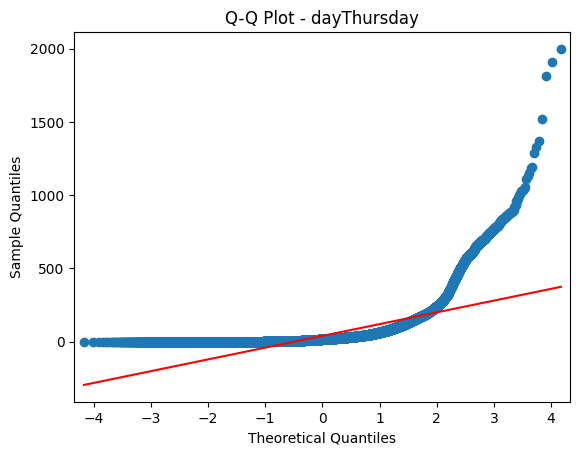

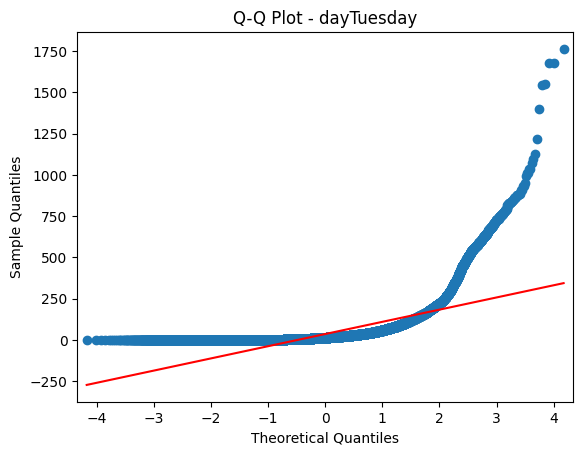

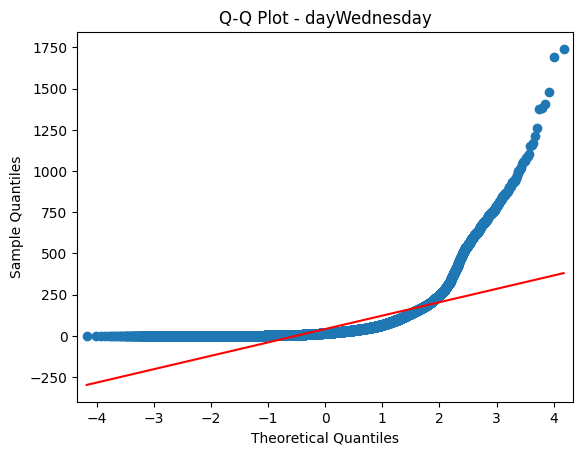

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

for day, group in df.groupby('dayofweek'):
    sm.qqplot(group['donations'], line='s')
    plt.title(f'Q-Q Plot - day{day}')
    plt.show()

In [ ]:
# Kruskal-Wallis test for day-of-week differences
dow_groups = [group['donations'].values for _, group in df.groupby('dayofweek')]
kruskal(*dow_groups)


KruskalResult(statistic=np.float64(12108.737616297487), pvalue=np.float64(0.0))

                 Friday         Monday       Saturday         Sunday  \
Friday     1.000000e+00   1.188401e-47   0.000000e+00   0.000000e+00   
Monday     1.188401e-47   1.000000e+00  8.667302e-221   0.000000e+00   
Saturday   0.000000e+00  8.667302e-221   1.000000e+00   0.000000e+00   
Sunday     0.000000e+00   0.000000e+00   0.000000e+00   1.000000e+00   
Thursday   0.000000e+00   0.000000e+00   5.399067e-23   0.000000e+00   
Tuesday    0.000000e+00  2.077234e-244   1.000000e+00   0.000000e+00   
Wednesday  0.000000e+00   0.000000e+00   1.764251e-59  1.344840e-245   

               Thursday        Tuesday      Wednesday  
Friday     0.000000e+00   0.000000e+00   0.000000e+00  
Monday     0.000000e+00  2.077234e-244   0.000000e+00  
Saturday   5.399067e-23   1.000000e+00   1.764251e-59  
Sunday     0.000000e+00   0.000000e+00  1.344840e-245  
Thursday   1.000000e+00   3.322297e-16   7.452784e-09  
Tuesday    3.322297e-16   1.000000e+00   3.203346e-48  
Wednesday  7.452784e-09   3.203

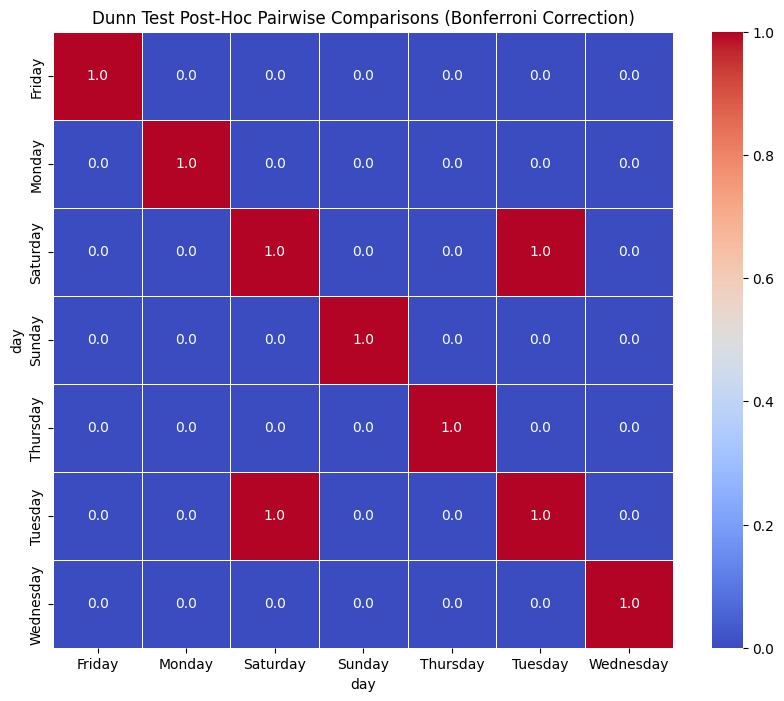

In [ ]:
import scikit_posthocs as sp

# Prepare data
dow_groups = [group['donations'].values for _, group in df.groupby('dayofweek')]
days = df['dayofweek'].unique()

# Run Dunn's test with Bonferroni correction
dunn_day_results = sp.posthoc_dunn(df, val_col='donations', group_col='dayofweek', p_adjust='bonferroni')

# Display results clearly
print(dunn_day_results)

# Generate heatmap for Dunn test results
plt.figure(figsize=(10, 8))
sns.heatmap(dunn_day_results, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Dunn Test Post-Hoc Pairwise Comparisons (Bonferroni Correction)')
plt.xlabel('day')
plt.ylabel('day')
plt.show()

In [ ]:
n = len(df)
epsilon_sq = 11950.37 / (n - 1)  # Using your Kruskal statistic
print(f"Effect size (ε²): {epsilon_sq:.3f}")
# Interpretation: >0.14 = large effect

Effect size (ε²): 0.026


In [ ]:
from scipy.stats import anderson

# Anderson-Darling test per month
ad_results = {}

for month, group in df.groupby('month'):
    result = anderson(group['donations'])
    ad_results[month] = {
        'statistic': result.statistic,
        'critical_values': result.critical_values,
        'significance_level': result.significance_level
    }

pd.DataFrame(ad_results).T

,statistic,critical_values,significance_level
1,5910.618711,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
2,5439.262029,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
3,5926.262455,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
4,5959.720542,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
5,6412.129417,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
6,5983.322458,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
7,6013.886366,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
8,6011.73743,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
9,5590.131474,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"
10,5682.916654,"[0.576, 0.656, 0.787, 0.918, 1.092]","[15.0, 10.0, 5.0, 2.5, 1.0]"


In [ ]:
# Anderson-Darling test per state and month
ad_results_state_month = {}

for state, state_group in df.groupby('state'):
    ad_results_state_month[state] = {}
    for month, month_group in state_group.groupby('month'):
        if len(month_group['donations']) > 7: # Minimum sample size for Anderson-Darling test
            result = anderson(month_group['donations'])
            ad_results_state_month[state][month] = {
                'statistic': result.statistic,
                'critical_values': result.critical_values,
                'significance_level': result.significance_level
            }
        else:
            ad_results_state_month[state][month] = "Sample size too small (<8) for Anderson-Darling test"

print(ad_results_state_month)

{'Johor': {1: {'statistic': np.float64(278.37922255224476), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.091]), 'significance_level': array([15. , 10. ,  5. ,  2.5,  1. ])}, 2: {'statistic': np.float64(241.818183042707), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.09 ]), 'significance_level': array([15. , 10. ,  5. ,  2.5,  1. ])}, 3: {'statistic': np.float64(297.2647004796072), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.091]), 'significance_level': array([15. , 10. ,  5. ,  2.5,  1. ])}, 4: {'statistic': np.float64(293.7361127618624), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.091]), 'significance_level': array([15. , 10. ,  5. ,  2.5,  1. ])}, 5: {'statistic': np.float64(297.58321661895025), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.091]), 'significance_level': array([15. , 10. ,  5. ,  2.5,  1. ])}, 6: {'statistic': np.float64(311.6731881521546), 'critical_values': array([0.575, 0.655, 0.786, 0.917, 1.091]), 'significanc

In [ ]:
# --- Kruskal-Wallis and Epsilon-squared for Day of Week ---
from scipy.stats import kruskal
dow_groups = [group["donations"].values for _, group in df.groupby("dayofweek")]
kw_dow = kruskal(*dow_groups)
n_dow = sum(len(g) for g in dow_groups)
eps2_dow = (kw_dow.statistic - 7 + 1) / (n_dow - 7)
print("Kruskal-Wallis by day of week: p =", round(kw_dow.pvalue, 5), " | Epsilon-squared =", round(eps2_dow, 4))

# --- Kruskal-Wallis and Epsilon-squared for Month ---
month_groups = [group["donations"].values for _, group in df.groupby("month")]
kw_month = kruskal(*month_groups)
n_month = sum(len(g) for g in month_groups)
eps2_month = (kw_month.statistic - 12 + 1) / (n_month - 12)
print("Kruskal-Wallis by month: p =", round(kw_month.pvalue, 5), " | Epsilon-squared =", round(eps2_month, 4))

# --- Kruskal-Wallis and Epsilon-squared for State ---
state_groups = [group["donations"].values for _, group in df.groupby("state") if group["donations"].nunique() > 1]
kw_state = kruskal(*state_groups)
n_state = sum(len(g) for g in state_groups)
eps2_state = (kw_state.statistic - 13 + 1) / (n_state - 13)
print("Kruskal-Wallis by state: p =", round(kw_state.pvalue, 5), " | Epsilon-squared =", round(eps2_state, 4))


Kruskal-Wallis by day of week: p = 0.0  | Epsilon-squared = 0.026
Kruskal-Wallis by month: p = 0.0  | Epsilon-squared = 0.0004
Kruskal-Wallis by state: p = 0.0  | Epsilon-squared = 0.201


In [ ]:
!pip install patsy --quiet

In [ ]:
!pip install ruptures --quiet

In [ ]:
!pip install ruptures --quiet

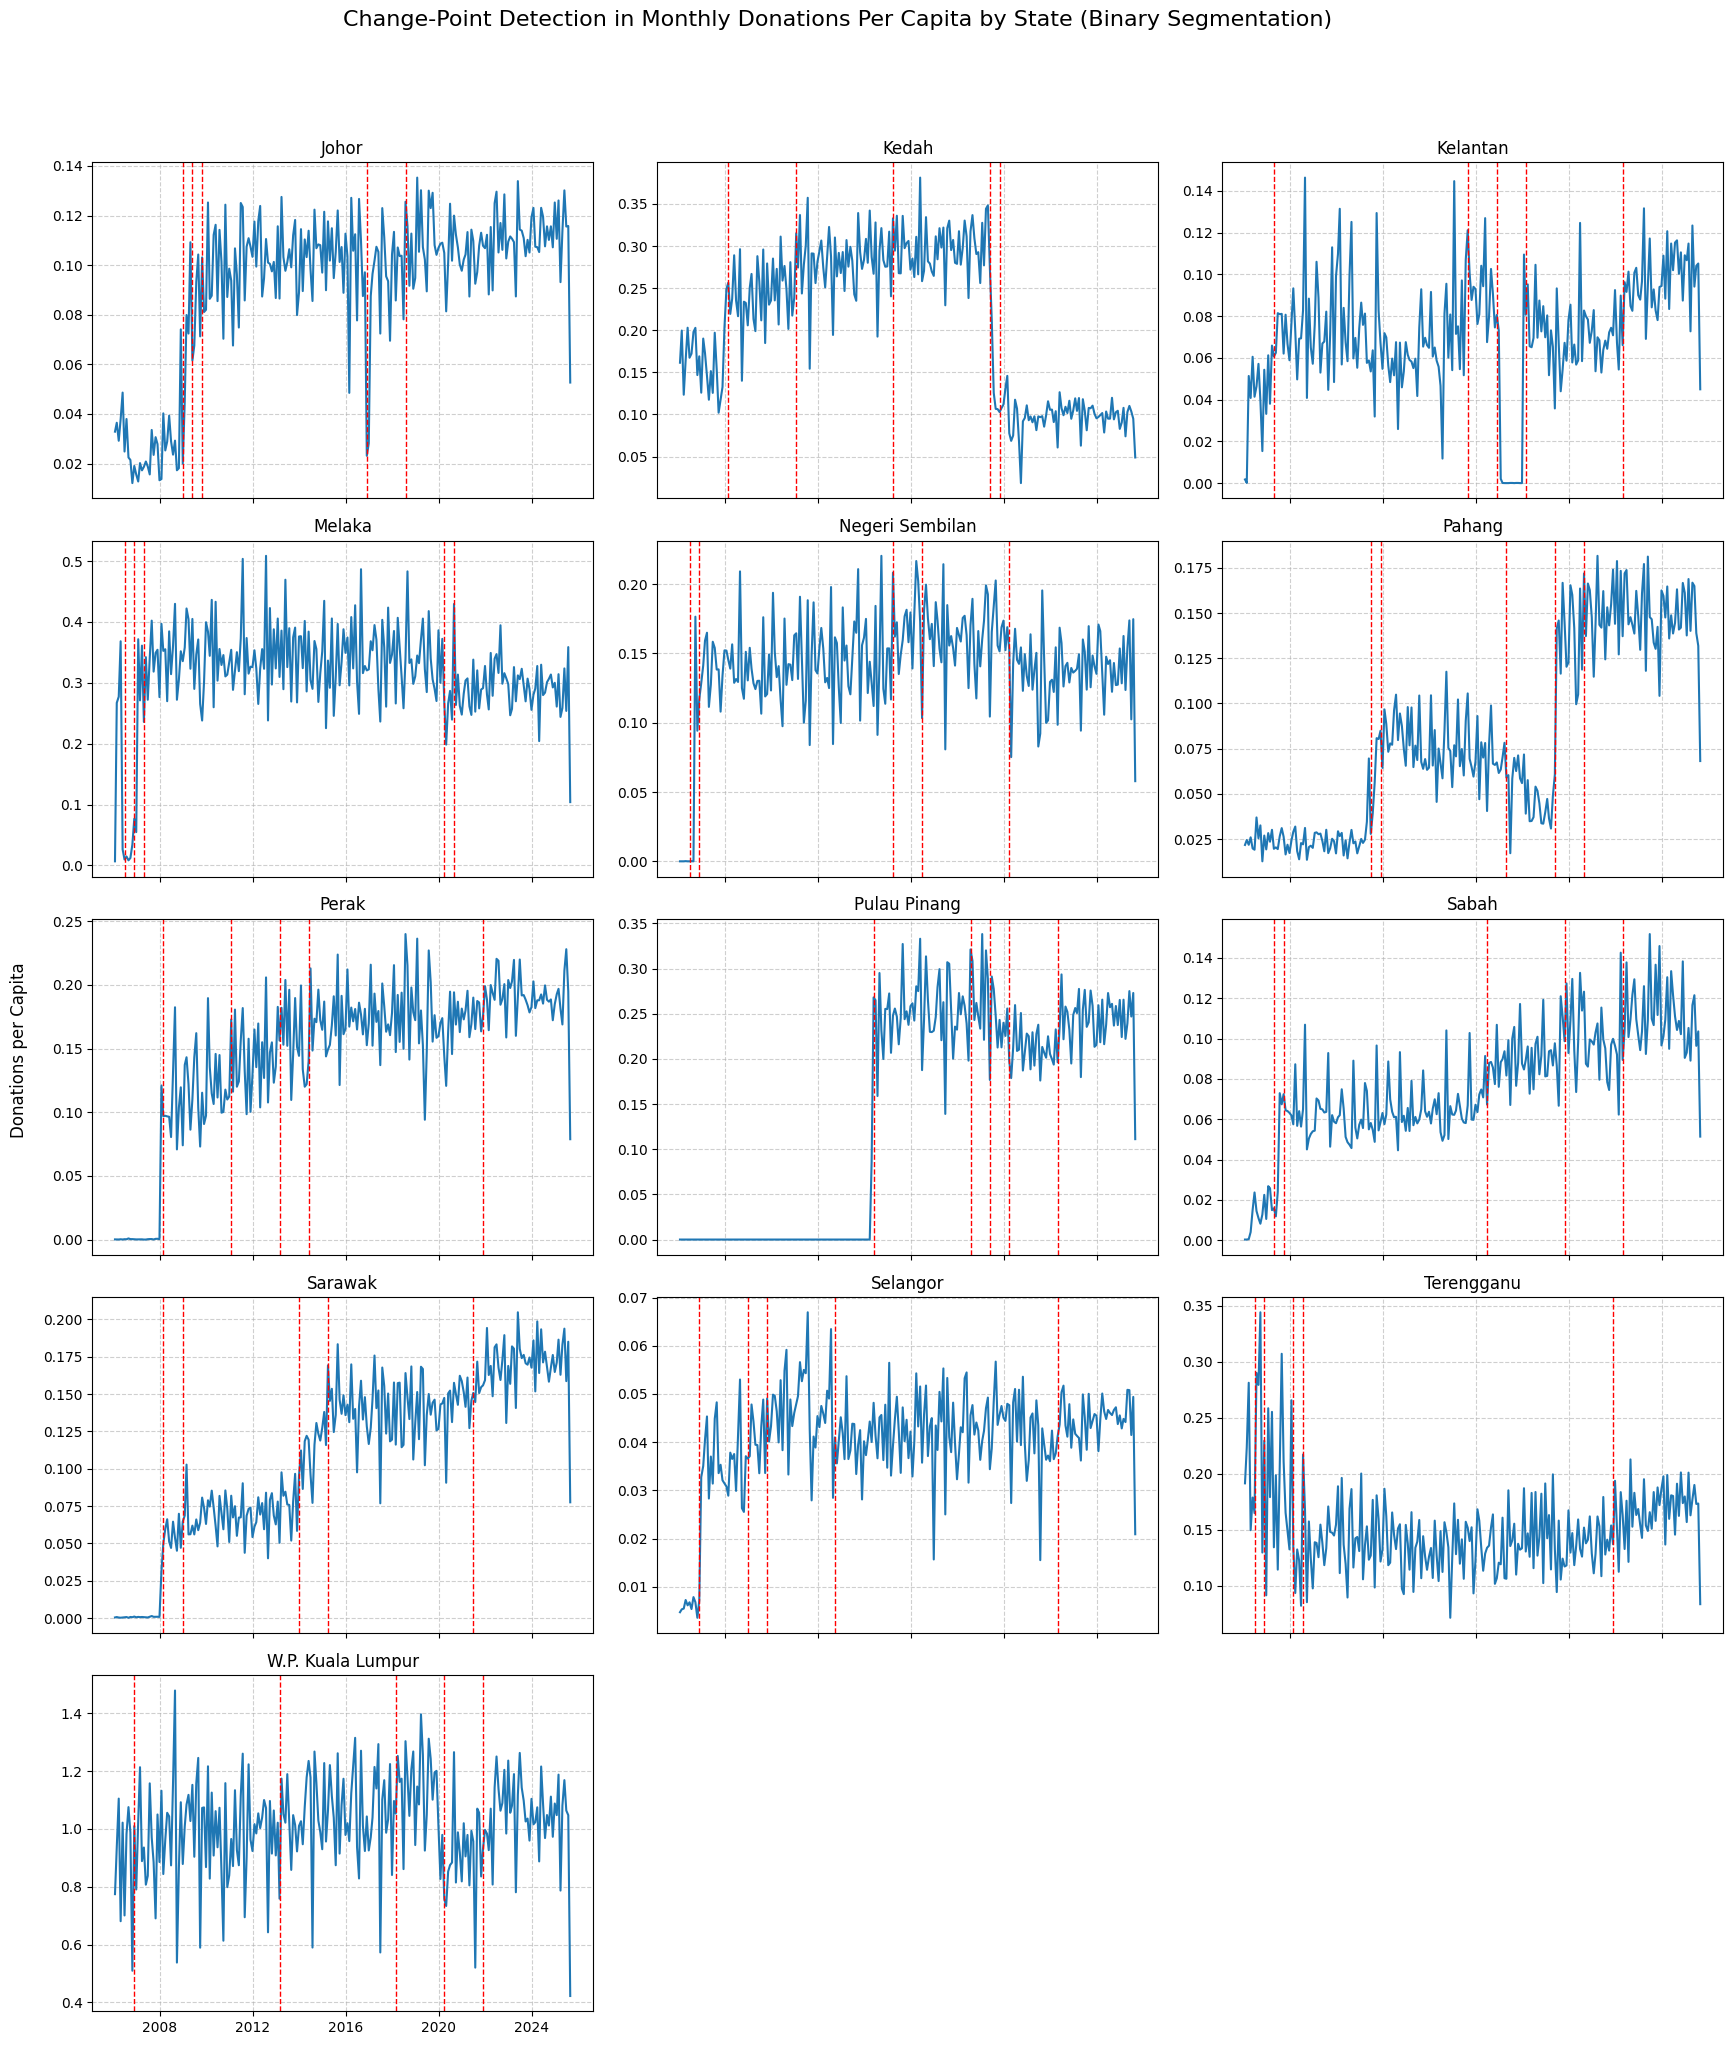

In [ ]:
# -------------------------------------------------------------
# Change-Point Detection on Monthly Donations Per Capita by State (Subplots)
# -------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ruptures as rpt
import math

# Assuming df and population DataFrames are already loaded and preprocessed
# as in previous cells (e.g., cell 01db90fc and TgH9i_xKvbit data loading parts)

# --- Load and Preprocess Blood Donations Data ---
# Load data
URL_DATA = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
df = pd.read_parquet(URL_DATA)

# Convert 'date' column to datetime
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])

# Ensure necessary columns exist (basic check)
if 'date' not in df.columns or 'donations' not in df.columns or 'blood_type' not in df.columns:
     print("Error: Required columns ('date', 'donations', 'blood_type') not found in the DataFrame.")
     # Stop execution or handle appropriately if columns are missing
else:
    # Basic preprocessing steps
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.day_name()
    df["blood_type"] = df["blood_type"].str.upper()
    valid_types = ["A", "B", "AB", "O"]
    df = df[df["blood_type"].isin(valid_types)]


# --- Load Population Data ---
URL_POP = 'https://storage.dosm.gov.my/population/population_state.parquet'
population = pd.read_parquet(URL_POP)
population['date'] = pd.to_datetime(population['date'])
population['year'] = population['date'].dt.year


# --- Prepare Monthly Donations Per Capita by State ---
population_state = (
    population.groupby(['year', 'state'])['population']
    .sum()
    .reset_index()
)

# Add a 'year' column also to the donations data (already done in preprocessing)

# Monthly aggregation of donations by state
monthly_state = (
    df.groupby([pd.Grouper(key="date", freq="ME"), "state"])['donations'] # Use ME for month end
    .sum()
    .reset_index()
)

# Add a 'year' column for merging with population
monthly_state['year'] = monthly_state['date'].dt.year

# Merge population data by state and year
monthly_state = monthly_state.merge(population_state, on=['year', 'state'], how='left')

# Calculate donations per capita
monthly_state['donations_per_capita'] = monthly_state.apply(
    lambda row: row['donations'] / row['population'] if row['population'] > 0 else np.nan,
    axis=1
)

# Remove rows with missing values
monthly_state = monthly_state.dropna(subset=['donations_per_capita'])

# --- Perform analysis for each state separately and plot in subplots ---
unique_states = sorted(monthly_state['state'].unique())
n_states = len(unique_states)

# Determine grid size for subplots
n_cols = 3 # You can adjust the number of columns
n_rows = math.ceil(n_states / n_cols)

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 6, n_rows * 4), sharex=True) # Adjusted figsize and added sharex
axes = axes.flatten() # Flatten the axes array for easy indexing

for i, state in enumerate(unique_states):
    ax = axes[i] # Get the current subplot axis
    df_state = monthly_state[monthly_state['state'] == state].copy()
    signal = df_state['donations_per_capita'].values

    # print(f"\nProcessing state: {state} ({len(signal)} months)") # Optional: Keep for debugging

    # Change-point analysis using Binary Segmentation (as in the original cell)
    try:
        if len(signal) >= (2 * 5 + 1):  # At least 11 data points
            algo = rpt.Binseg(model="l2").fit(signal)
            bkps = algo.predict(n_bkps=5) # Detect up to 5 change points
        else:
            bkps = []
            # print(f"Not enough data points for {state} to detect 5 breakpoints.") # Optional: Keep for debugging

    except Exception as e:
        # print(f"Error in change-point detection for {state}: {e}") # Optional: Keep for debugging
        bkps = []

    # --- Plot on Subplot ---
    ax.plot(df_state['date'], signal, label="Donations per Capita")

    if bkps:
        valid_bkps = [cp for cp in bkps if 0 <= cp < len(signal)]
        for cp in valid_bkps:
            if 0 <= cp < len(df_state): # Check if cp is a valid index
                 ax.axvline(x=df_state['date'].iloc[cp],
                            color="red", linestyle="--", linewidth=1) # Reduced linewidth for subplots

    ax.set_title(state) # Set subplot title to state name
    # ax.set_xlabel("Date") # Remove individual x-labels if sharex is True
    # ax.set_ylabel("Donations per Capita") # Remove individual y-labels
    ax.grid(True, linestyle='--', alpha=0.6)
    # ax.legend() # Legends might clutter subplots

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Add a common Y-label and potentially a common X-label if not sharing x-axis
fig.text(0.04, 0.5, 'Donations per Capita', va='center', rotation='vertical', fontsize=12)
fig.suptitle('Change-Point Detection in Monthly Donations Per Capita by State (Binary Segmentation)', fontsize=16, y=1.02) # Add a main title

plt.tight_layout(rect=[0.05, 0, 1, 0.98]) # Adjust layout to make space for suptitle
plt.show()


In [ ]:
!pip install ruptures --quiet

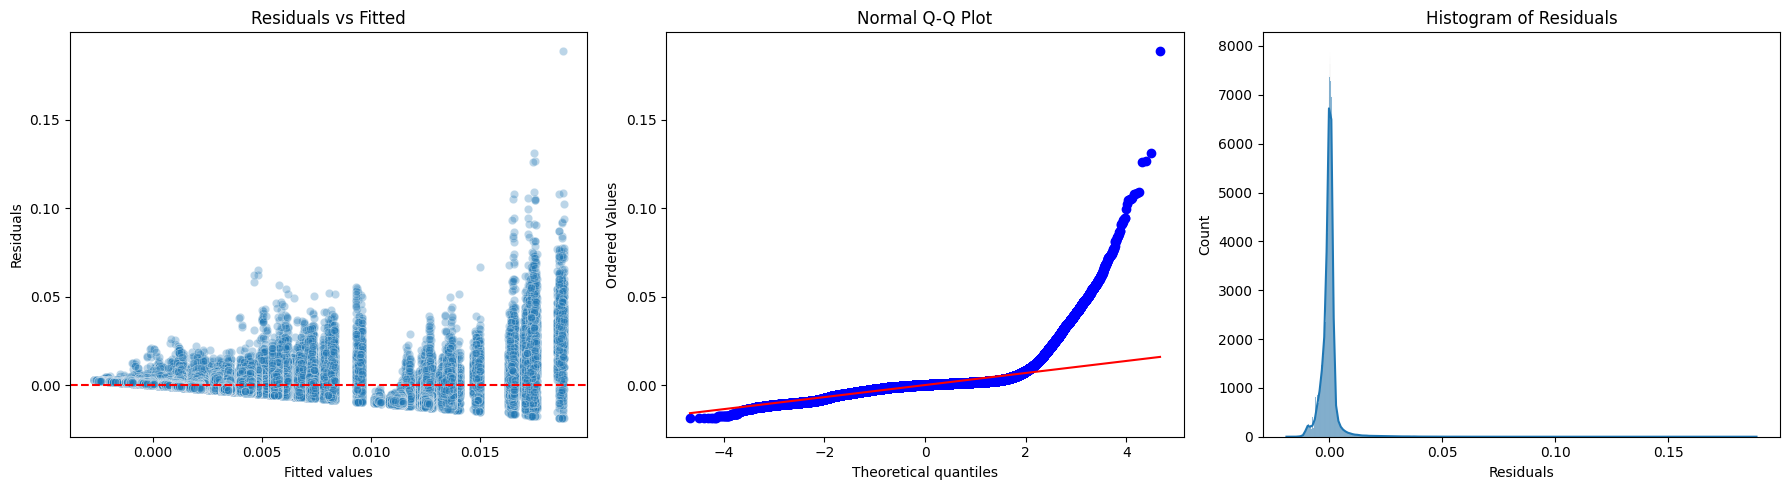

                             OLS Regression Results                             
Dep. Variable:     donations_per_capita   R-squared:                       0.458
Model:                              OLS   Adj. R-squared:                  0.458
Method:                   Least Squares   F-statistic:                 1.195e+04
Date:                  Thu, 14 Aug 2025   Prob (F-statistic):               0.00
Time:                          17:04:50   Log-Likelihood:             1.8819e+06
No. Observations:                465725   AIC:                        -3.764e+06
Df Residuals:                    465691   BIC:                        -3.763e+06
Df Model:                            33                                         
Covariance Type:              nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
# ---[ Install required package ]---
!pip install pyarrow --quiet

# ---[ Imports ]---
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import probplot

# ---[ Load blood donation data ]---
blood_url = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
donations = pd.read_parquet(blood_url)
donations['date'] = pd.to_datetime(donations['date'])
donations["year"] = donations["date"].dt.year
donations["month"] = donations["date"].dt.month
donations["dayofweek"] = donations["date"].dt.day_name()

# ---[ Load population data ]---
population_url = 'https://storage.dosm.gov.my/population/population_state.parquet'
population = pd.read_parquet(population_url)
population['date'] = pd.to_datetime(population['date'])
population['year'] = population['date'].dt.year
population_summary = population.groupby(['state', 'year'])['population'].sum().reset_index()

# ---[ Merge and prepare data ]---
merged = donations.merge(population_summary, on=["state", "year"], how="left")
merged['donations_per_capita'] = merged['donations'] / merged['population']
merged['blood_type'] = merged['blood_type'].str.lower()

# ---[ Fit regression model ]---
formula = 'donations_per_capita ~ C(state) + C(month) + C(dayofweek) + C(blood_type)'
model_final = smf.ols(formula, data=merged).fit()

# ---[ Diagnostic plots ]---
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Residuals vs Fitted
fitted_vals = model_final.fittedvalues
residuals = model_final.resid
sns.scatterplot(x=fitted_vals, y=residuals, ax=axes[0], alpha=0.3)
axes[0].axhline(0, color='red', linestyle='--')
axes[0].set_title('Residuals vs Fitted')
axes[0].set_xlabel('Fitted values')
axes[0].set_ylabel('Residuals')

# Q-Q plot
probplot(residuals, dist="norm", plot=axes[1])
axes[1].set_title('Normal Q-Q Plot')

# Histogram
sns.histplot(residuals, kde=True, ax=axes[2])
axes[2].set_title('Histogram of Residuals')
axes[2].set_xlabel('Residuals')

plt.tight_layout()
plt.show()

# ---[ Summary ]---
print(model_final.summary())


In [ ]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import MinMaxScaler
from statsmodels.genmod.families import Gamma, Tweedie

# --- Load and preprocess (as before) ---
URL_POP = 'https://storage.dosm.gov.my/population/population_state.parquet'
population = pd.read_parquet(URL_POP)
population['date'] = pd.to_datetime(population['date'])
population['year'] = population['date'].dt.year
population_summary = population.groupby(['state', 'year'])['population'].sum().reset_index()

URL_DON = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
donations = pd.read_parquet(URL_DON)
donations['date'] = pd.to_datetime(donations['date'])
donations['year'] = donations['date'].dt.year
donations['month'] = donations['date'].dt.month
donations['dayofweek'] = donations['date'].dt.day_name()
donations['blood_type'] = donations['blood_type'].str.lower()

# --- Merge and outcome variable ---
data = donations.merge(population_summary, on=['state', 'year'], how='left')
data = data[data['population'] > 0]
data['donations_per_capita'] = data['donations'] / data['population']
data = data[data['donations_per_capita'].notna() & (data['donations_per_capita'] > 0)]

# --- Gamma GLM ---
gamma_model = smf.glm(
    formula='donations_per_capita ~ C(state) + C(month) + C(dayofweek) + C(blood_type)',
    data=data,
    family=Gamma(link=sm.genmod.families.links.log())
).fit()

# --- Tweedie GLM ---
tweedie_model = smf.glm(
    formula='donations_per_capita ~ C(state) + C(month) + C(dayofweek) + C(blood_type)',
    data=data,
    family=Tweedie(link=sm.genmod.families.links.log(), var_power=1.5)  # try 1.3 to 1.9
).fit()

# --- Beta Regression: Normalize to (0, 1) ---
beta_data = data.copy()
scaler = MinMaxScaler(feature_range=(0.001, 0.999))
beta_data['don_pc_scaled'] = scaler.fit_transform(beta_data[['donations_per_capita']])

# Model with GLM approximated to beta via binomial family (not exact but a good proxy)
beta_model = smf.glm(
    formula='don_pc_scaled ~ C(state) + C(month) + C(dayofweek) + C(blood_type)',
    data=beta_data,
    family=sm.families.Binomial()
).fit()

# --- Compare AIC ---
print("Gamma GLM:     AIC =", gamma_model.aic)
print("Tweedie GLM:   AIC =", tweedie_model.aic)
print("Beta GLM (scaled): AIC =", beta_model.aic)


/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


Gamma GLM:     AIC = -4430512.750904764
Tweedie GLM:   AIC = -4310396.713653737
Beta GLM (scaled): AIC = 44430.329453533646


In [ ]:
# ---[ Install required packages ]---
!pip install pyarrow statsmodels pandas fastparquet --quiet

# ---[ Imports ]---
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import numpy as np

# ---[ Load and preprocess population data ]---
URL_POP = 'https://storage.dosm.gov.my/population/population_state.parquet'
population = pd.read_parquet(URL_POP, engine='pyarrow')
population['date'] = pd.to_datetime(population['date'])
population['year'] = population['date'].dt.year
population_summary = population.groupby(['state', 'year'])['population'].sum().reset_index()

# ---[ Load and preprocess donations data ]---
URL_DON = 'https://storage.data.gov.my/healthcare/blood_donations_state.parquet'
donations = pd.read_parquet(URL_DON, engine='pyarrow')
donations['date'] = pd.to_datetime(donations['date'])
donations['year'] = donations['date'].dt.year
donations['month'] = donations['date'].dt.month
donations['dayofweek'] = donations['date'].dt.day_name()
donations['blood_type'] = donations['blood_type'].str.lower()

# ---[ Merge and compute per-capita donations ]---
data = donations.merge(population_summary, on=['state', 'year'], how='left')
data = data[data['population'] > 0]
data['donations_per_capita'] = data['donations'] / data['population']
data = data[data['donations_per_capita'] > 0]  # Remove zero donations for log link
data = data.dropna()

# ---[ Fit Gamma GLM with log link ]---
model = smf.glm(
    formula='donations_per_capita ~ C(state) + C(month) + C(dayofweek) + C(blood_type)',
    data=data,
    family=sm.families.Gamma(link=sm.families.links.Log())
).fit()

# ---[ Summary output ]---
print(model.summary())


                  Generalized Linear Model Regression Results                   
Dep. Variable:     donations_per_capita   No. Observations:               398204
Model:                              GLM   Df Residuals:                   398170
Model Family:                     Gamma   Df Model:                           33
Link Function:                      Log   Scale:                         0.68751
Method:                            IRLS   Log-Likelihood:             2.2153e+06
Date:                  Thu, 14 Aug 2025   Deviance:                   2.5730e+05
Time:                          17:07:01   Pearson chi2:                 2.74e+05
No. Iterations:                      19   Pseudo R-squ. (CS):             0.8736
Covariance Type:              nonrobust                                         
                                    coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------

In [ ]:
from scipy.stats import kruskal
import pymannkendall as mk
import warnings

# 1. Create an empty list to store the results for each state.
results_list = []

# 2. Get a list of unique states from the df_annual_merged DataFrame.
# Using annual_per_capita_state as it contains the states with valid annual data
unique_states = annual_per_capita_state['state'].unique()

# 3. Start a loop that iterates through each unique state.
for state in unique_states:
    # 4. Filter the df_merged DataFrame to get data for the current state.
    state_df = df_merged[df_merged['state'] == state].copy()

    # 5. Filter the annual_per_capita_state DataFrame to get annual data for the current state.
    state_annual_df = annual_per_capita_state[annual_per_capita_state['state'] == state].copy()

    # --- Monthly Variance Analysis (Kruskal-Wallis) ---
    # 6. Group by 'month' and extract 'donations_per_capita'.
    month_groups = []
    # Get unique months present in the state's data
    state_months = state_df['month'].unique()
    for month in sorted(state_months): # Sort for consistent order
        month_data = state_df[state_df['month'] == month]['donations_per_capita'].dropna().values
        # Ensure group is not empty and has enough unique values for Kruskal-Wallis
        if len(month_data) > 1 and len(np.unique(month_data)) > 1:
             month_groups.append(month_data)
        else:
             # Append empty array or handle as needed if a month has insufficient data
             month_groups.append(np.array([]))

    # 7. Perform Kruskal-Wallis test on monthly groups.
    kruskal_month_h = np.nan
    kruskal_month_p = np.nan
    # Check if there are at least 2 non-empty groups with variance > 0
    valid_month_groups = [g for g in month_groups if len(g) > 1 and np.var(g) > 1e-9]
    if len(valid_month_groups) >= 2:
         try:
             kruskal_month_stat, kruskal_month_p = kruskal(*valid_month_groups)
             kruskal_month_h = kruskal_month_stat # Kruskal returns H statistic
         except ValueError:
             # Handle cases where kruskal might fail (e.g., all data points are identical within groups)
             pass


    # 8. Calculate epsilon squared for monthly Kruskal-Wallis test.
    epsilon_sq_month = np.nan
    if not np.isnan(kruskal_month_h):
        n_month = sum(len(g) for g in valid_month_groups)
        k_month = len(valid_month_groups) # Number of groups used in the test
        if n_month > k_month: # Avoid division by zero or negative
            epsilon_sq_month = (kruskal_month_h - (k_month - 1)) / (n_month - k_month)
        else:
             epsilon_sq_month = 0 # Small sample size, effect size close to 0

    # --- Daily Variance Analysis (Kruskal-Wallis) ---
    # 9. Group by 'dayofweek' and extract 'donations_per_capita'.
    day_groups = []
    # Define the order of days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day in day_order: # Iterate through ordered days
        day_data = state_df[state_df['dayofweek'] == day]['donations_per_capita'].dropna().values
        # Ensure group is not empty and has enough unique values for Kruskal-Wallis
        if len(day_data) > 1 and len(np.unique(day_data)) > 1:
             day_groups.append(day_data)
        else:
             # Append empty array or handle as needed if a day has insufficient data
             day_groups.append(np.array([]))

    # 10. Perform Kruskal-Wallis test on daily groups.
    kruskal_day_h = np.nan
    kruskal_day_p = np.nan
    # Check if there are at least 2 non-empty groups with variance > 0
    valid_day_groups = [g for g in day_groups if len(g) > 1 and np.var(g) > 1e-9]

    if len(valid_day_groups) >= 2:
        try:
            kruskal_day_stat, kruskal_day_p = kruskal(*valid_day_groups)
            kruskal_day_h = kruskal_day_stat # Kruskal returns H statistic
        except ValueError:
             # Handle cases where kruskal might fail
             pass

    # 11. Calculate epsilon squared for daily Kruskal-Wallis test.
    epsilon_sq_day = np.nan
    if not np.isnan(kruskal_day_h):
        n_day = sum(len(g) for g in valid_day_groups)
        k_day = len(valid_day_groups) # Number of groups used in the test
        if n_day > k_day: # Avoid division by zero or negative
             epsilon_sq_day = (kruskal_day_h - (k_day - 1)) / (n_day - k_day)
        else:
             epsilon_sq_day = 0 # Small sample size, effect size close to 0


    # --- Annual Trend Analysis (Mann-Kendall) ---
    # 12. Check if there is enough data for Mann-Kendall test.
    # Mann-Kendall typically requires at least 8-10 data points.
    min_years_for_mk = 8 # Standard recommendation is >= 8 or 10

    mk_trend = None
    mk_h = None
    mk_p = np.nan
    mk_z = np.nan
    mk_tau = np.nan
    mk_slope = np.nan
    mk_intercept = np.nan

    # Ensure the annual data has enough rows and the required columns exist
    if len(state_annual_df) >= min_years_for_mk and 'year' in state_annual_df.columns and 'annual_donations_per_capita' in state_annual_df.columns:
        # 13. Perform Mann-Kendall test.
        # Suppress potential warnings from Mann-Kendall due to data characteristics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                # Mann-Kendall requires a Series or array of values
                mk_results = mk.original_test(state_annual_df['annual_donations_per_capita'].values)
                mk_trend = mk_results.trend
                mk_h = mk_results.h # Boolean: True if trend is significant
                mk_p = mk_results.p
                mk_z = mk_results.z
                mk_tau = mk_results.Tau
                mk_slope = mk_results.slope
                mk_intercept = mk_results.intercept # Note: intercept is for the trend line, not the original data

            except Exception as e:
                # Handle any errors during Mann-Kendall test
                print(f"Mann-Kendall test failed for {state}: {e}")
                # Results remain as NaNs or None
    # 14. Assign placeholder values if not enough data.
    # Results are already initialized to NaNs/None if the if condition in 12 is not met


    # 15. Create a dictionary to store the collected results for the current state.
    state_results = {
        'state': state,
        'Kruskal_Month_H': kruskal_month_h,
        'Kruskal_Month_p': kruskal_month_p,
        'Epsilon_Squared_Month': epsilon_sq_month,
        'Kruskal_Day_H': kruskal_day_h,
        'Kruskal_Day_p': kruskal_day_p,
        'Epsilon_Squared_Day': epsilon_sq_day,
        'MK_Trend': mk_trend,
        'MK_H': mk_h,
        'MK_p': mk_p,
        'MK_Z': mk_z,
        'MK_Tau': mk_tau,
        'MK_Slope': mk_slope,
        'MK_Intercept': mk_intercept
    }

    # 16. Append the state's results dictionary to the list.
    results_list.append(state_results)

In [ ]:
from scipy.stats import kruskal
import pymannkendall as mk
import warnings
import numpy as np
import pandas as pd # Import pandas

# Assuming df_merged and annual_per_capita_state DataFrames are available from the previous step

# 1. Create an empty list to store the results for each state.
results_list = []

# 2. Get a list of unique states from the annual_per_capita_state DataFrame.
# Using annual_per_capita_state as it contains the states with valid annual data
unique_states = annual_per_capita_state['state'].unique()

# 3. Start a loop that iterates through each unique state.
for state in unique_states:
    # 4. Filter the df_merged DataFrame to get data for the current state.
    state_df = df_merged[df_merged['state'] == state].copy()

    # 5. Filter the annual_per_capita_state DataFrame to get annual data for the current state.
    state_annual_df = annual_per_capita_state[annual_per_capita_state['state'] == state].copy()


    # --- Monthly Variance Analysis (Kruskal-Wallis) on Per Capita Data ---
    # 6. Group by 'month' and extract 'donations_per_capita'.
    month_groups = []
    # Get unique months present in the state's data
    state_months = state_df['month'].unique()
    for month in sorted(state_months): # Sort for consistent order
        month_data = state_df[state_df['month'] == month]['donations_per_capita'].dropna().values
        # Ensure group is not empty and has enough unique values for Kruskal-Wallis
        if len(month_data) > 1 and len(np.unique(month_data)) > 1:
             month_groups.append(month_data)
        else:
             # Append empty array or handle as needed if a month has insufficient data
             month_groups.append(np.array([]))


    # 7. Perform Kruskal-Wallis test on monthly groups.
    kruskal_month_h = np.nan
    kruskal_month_p = np.nan
    # Check if there are at least 2 non-empty groups with variance > 0
    valid_month_groups = [g for g in month_groups if len(g) > 1 and np.var(g) > 1e-9]
    if len(valid_month_groups) >= 2:
         # Suppress UserWarning for low numbers of ties in Kruskal
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                kruskal_month_stat, kruskal_month_p = kruskal(*valid_month_groups)
                kruskal_month_h = kruskal_month_stat # Kruskal returns H statistic
            except ValueError:
                 # Handle cases where kruskal might fail (e.g., all data points are identical within groups)
                 pass


    # 8. Calculate epsilon squared for monthly Kruskal-Wallis test.
    epsilon_sq_month = np.nan
    if not np.isnan(kruskal_month_h):
        n_month = sum(len(g) for g in valid_month_groups)
        k_month = len(valid_month_groups) # Number of groups used in the test
        if n_month > k_month: # Avoid division by zero or negative
            epsilon_sq_month = (kruskal_month_h - (k_month - 1)) / (n_month - k_month)
        else:
             epsilon_sq_month = 0 # Small sample size, effect size close to 0


    # --- Daily Variance Analysis (Kruskal-Wallis) on Per Capita Data ---
    # 9. Group by 'dayofweek' and extract 'donations_per_capita'.
    day_groups = []
    # Define the order of days
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    for day in day_order: # Iterate through ordered days
        day_data = state_df[state_df['dayofweek'] == day]['donations_per_capita'].dropna().values
        # Ensure group is not empty and has enough unique values for Kruskal-Wallis
        if len(day_data) > 1 and len(np.unique(day_data)) > 1:
             day_groups.append(day_data)
        else:
             # Append empty array or handle as needed if a day has insufficient data
             day_groups.append(np.array([]))

    # 10. Perform Kruskal-Wallis test on daily groups.
    kruskal_day_h = np.nan
    kruskal_day_p = np.nan
    # Check if there are at least 2 non-empty groups with variance > 0
    valid_day_groups = [g for g in day_groups if len(g) > 1 and np.var(g) > 1e-9]

    if len(valid_day_groups) >= 2:
        # Suppress UserWarning for low numbers of ties in Kruskal
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", UserWarning)
            try:
                kruskal_day_stat, kruskal_day_p = kruskal(*valid_day_groups)
                kruskal_day_h = kruskal_day_stat # Kruskal returns H statistic
            except ValueError:
                 # Handle cases where kruskal might fail
                 pass

    # 11. Calculate epsilon squared for daily Kruskal-Wallis test.
    epsilon_sq_day = np.nan
    if not np.isnan(kruskal_day_h):
        n_day = sum(len(g) for g in valid_day_groups)
        k_day = len(valid_day_groups) # Number of groups used in the test
        if n_day > k_day: # Avoid division by zero or negative
             epsilon_sq_day = (kruskal_day_h - (k_day - 1)) / (n_day - k_day)
        else:
             epsilon_sq_day = 0 # Small sample size, effect size close to 0


    # --- Annual Trend Analysis (Mann-Kendall) on Per Capita Data ---
    # 12. Check if there is enough data for Mann-Kendall test.
    # Mann-Kendall typically requires at least 8-10 data points.
    min_years_for_mk = 8 # Standard recommendation is >= 8 or 10

    mk_trend = None
    mk_h = None
    mk_p = np.nan
    mk_z = np.nan
    mk_tau = np.nan
    mk_slope = np.nan
    mk_intercept = np.nan

    # Ensure the annual data has enough rows and the required columns exist
    if len(state_annual_df) >= min_years_for_mk and 'year' in state_annual_df.columns and 'annual_donations_per_capita' in state_annual_df.columns:
        # 13. Perform Mann-Kendall test.
        # Suppress potential warnings from Mann-Kendall due to data characteristics
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            try:
                # Mann-Kendall requires a Series or array of values
                mk_results = mk.original_test(state_annual_df['annual_donations_per_capita'].values)
                mk_trend = mk_results.trend
                mk_h = mk_results.h # Boolean: True if trend is significant
                mk_p = mk_results.p
                mk_z = mk_results.z
                mk_tau = mk_results.Tau
                mk_slope = mk_results.slope
                mk_intercept = mk_results.intercept # Note: intercept is for the trend line, not the original data

            except Exception as e:
                # Handle any errors during Mann-Kendall test
                print(f"Mann-Kendall test failed for {state}: {e}")
                # Results remain as NaNs or None
    # 14. Assign placeholder values if not enough data.
    # Results are already initialized to NaNs/None if the if condition in 12 is not met


    # 15. Create a dictionary to store the collected results for the current state.
    state_results = {
        'state': state,
        'Kruskal_Month_H': kruskal_month_h,
        'Kruskal_Month_p': kruskal_month_p,
        'Epsilon_Squared_Month': epsilon_sq_month,
        'Kruskal_Day_H': kruskal_day_h,
        'Kruskal_Day_p': kruskal_day_p,
        'Epsilon_Squared_Day': epsilon_sq_day,
        'MK_Trend': mk_trend,
        'MK_H': mk_h,
        'MK_p': mk_p,
        'MK_Z': mk_z,
        'MK_Tau': mk_tau,
        'MK_Slope': mk_slope,
        'MK_Intercept': mk_intercept
    }

    # 16. Append the state's results dictionary to the list.
    results_list.append(state_results)

# Print a message indicating that the analysis for all states is complete
print("Analysis for all states complete. Results are stored in 'results_list'.")

Analysis for all states complete. Results are stored in 'results_list'.


In [ ]:
import pandas as pd

# Assuming results_list is available from the previous step

# 1. Convert the list of results dictionaries into a pandas DataFrame.
df_summary_results = pd.DataFrame(results_list)

# 2. Display the summary DataFrame.
display(df_summary_results)

,state,Kruskal_Month_H,Kruskal_Month_p,Epsilon_Squared_Month,Kruskal_Day_H,Kruskal_Day_p,Epsilon_Squared_Day,MK_Trend,MK_H,MK_p,MK_Z,MK_Tau,MK_Slope,MK_Intercept
0,Johor,41.821863,1.738824e-05,8.885454e-04,6305.678035,0.000000e+00,0.181584,increasing,True,6.653301e-05,3.988355,0.672515,0.384282,16.326169
1,Kedah,102.563476,5.541571e-17,2.639630e-03,550.770600,9.631400e-116,0.015703,no trend,False,8.887056e-01,-0.139942,-0.029240,-0.379073,50.014265
2,Kelantan,64.495918,1.340355e-09,1.542202e-03,1059.648203,1.119925e-225,0.030371,no trend,False,5.886224e-02,1.889221,0.321637,0.278498,11.727266
3,Melaka,86.624618,7.621003e-14,2.180138e-03,3096.879480,0.000000e+00,0.089092,no trend,False,1.237152e-01,-1.539365,-0.263158,-0.287051,67.712711
4,Negeri Sembilan,68.107689,2.792347e-10,1.646324e-03,937.220892,3.369120e-199,0.026842,no trend,False,6.746119e-01,0.419827,0.076023,0.084657,26.627863
5,Pahang,71.808596,5.528062e-11,1.753015e-03,1773.461772,0.000000e+00,0.050946,increasing,True,1.578128e-04,3.778442,0.637427,1.450922,1.454486
6,Perak,78.773271,2.546806e-12,1.953796e-03,1216.339851,1.391891e-259,0.034887,increasing,True,9.682689e-07,4.897980,0.824561,1.105657,22.169277
7,Pulau Pinang,44.225542,6.635398e-06,9.578396e-04,540.273843,1.763514e-113,0.015400,increasing,True,2.185129e-03,3.063844,0.497076,2.997012,13.499304
8,Sabah,35.908754,1.752503e-04,7.180798e-04,533.247576,5.764818e-112,0.015198,increasing,True,3.257703e-07,5.107893,0.859649,0.797931,5.602386
9,Sarawak,81.641495,7.099255e-13,2.036482e-03,2984.085057,0.000000e+00,0.085841,increasing,True,4.822083e-08,5.457749,0.918129,1.634603,11.552858


--- Normality Check for Donations Per Capita by Month ---
Month 1: Anderson-Darling Stat = 6118.2259
  Does NOT appear normally distributed (stat >= 0.7870)
Month 2: Anderson-Darling Stat = 5644.7116
  Does NOT appear normally distributed (stat >= 0.7870)
Month 3: Anderson-Darling Stat = 6116.7944
  Does NOT appear normally distributed (stat >= 0.7870)
Month 4: Anderson-Darling Stat = 6098.0666
  Does NOT appear normally distributed (stat >= 0.7870)
Month 5: Anderson-Darling Stat = 6544.3931
  Does NOT appear normally distributed (stat >= 0.7870)
Month 6: Anderson-Darling Stat = 6066.1179
  Does NOT appear normally distributed (stat >= 0.7870)
Month 7: Anderson-Darling Stat = 6214.3807
  Does NOT appear normally distributed (stat >= 0.7870)
Month 8: Anderson-Darling Stat = 6350.6012
  Does NOT appear normally distributed (stat >= 0.7870)
Month 9: Anderson-Darling Stat = 5902.4353
  Does NOT appear normally distributed (stat >= 0.7870)
Month 10: Anderson-Darling Stat = 6107.3728
  Does 

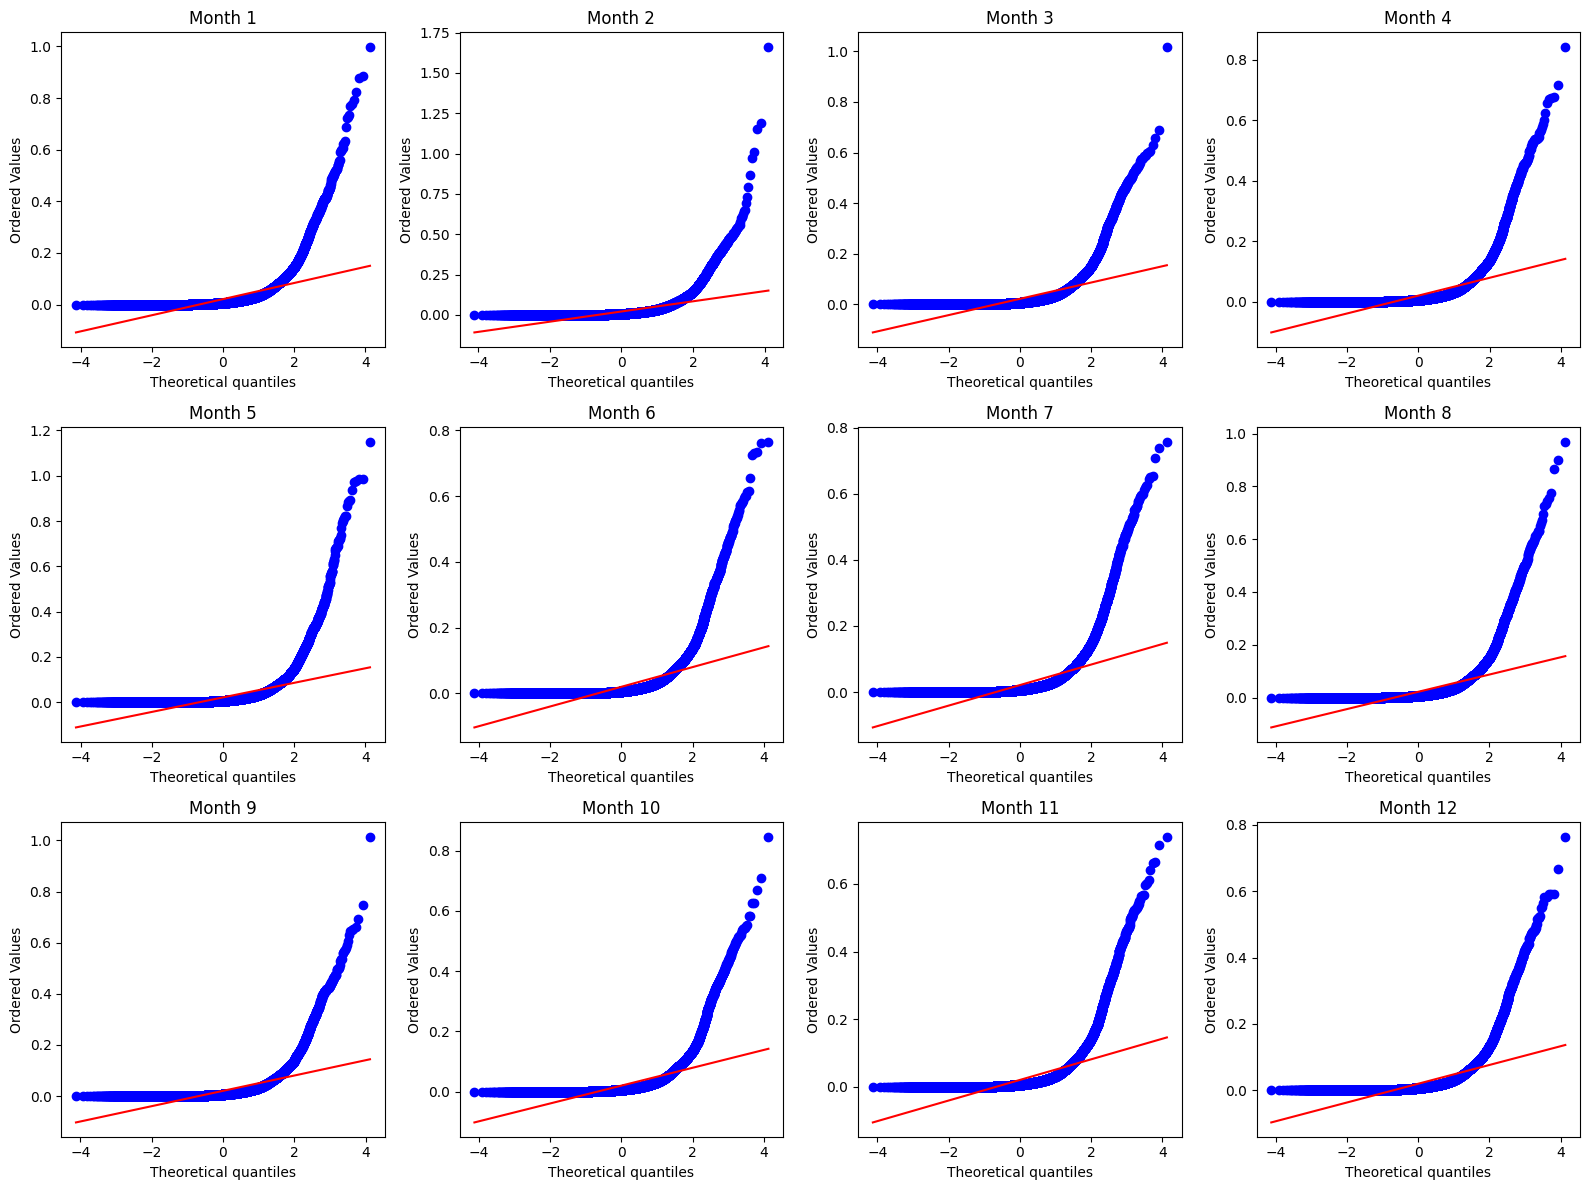


--- Normality Check for Donations Per Capita by Day of Week ---
Day Monday: Anderson-Darling Stat = 10285.6989
  Does NOT appear normally distributed (stat >= 0.7870)
Day Tuesday: Anderson-Darling Stat = 10322.9939
  Does NOT appear normally distributed (stat >= 0.7870)
Day Wednesday: Anderson-Darling Stat = 10067.4307
  Does NOT appear normally distributed (stat >= 0.7870)
Day Thursday: Anderson-Darling Stat = 10326.8637
  Does NOT appear normally distributed (stat >= 0.7870)
Day Friday: Anderson-Darling Stat = 11474.6849
  Does NOT appear normally distributed (stat >= 0.7870)
Day Saturday: Anderson-Darling Stat = 10357.9718
  Does NOT appear normally distributed (stat >= 0.7870)
Day Sunday: Anderson-Darling Stat = 9302.9672
  Does NOT appear normally distributed (stat >= 0.7870)


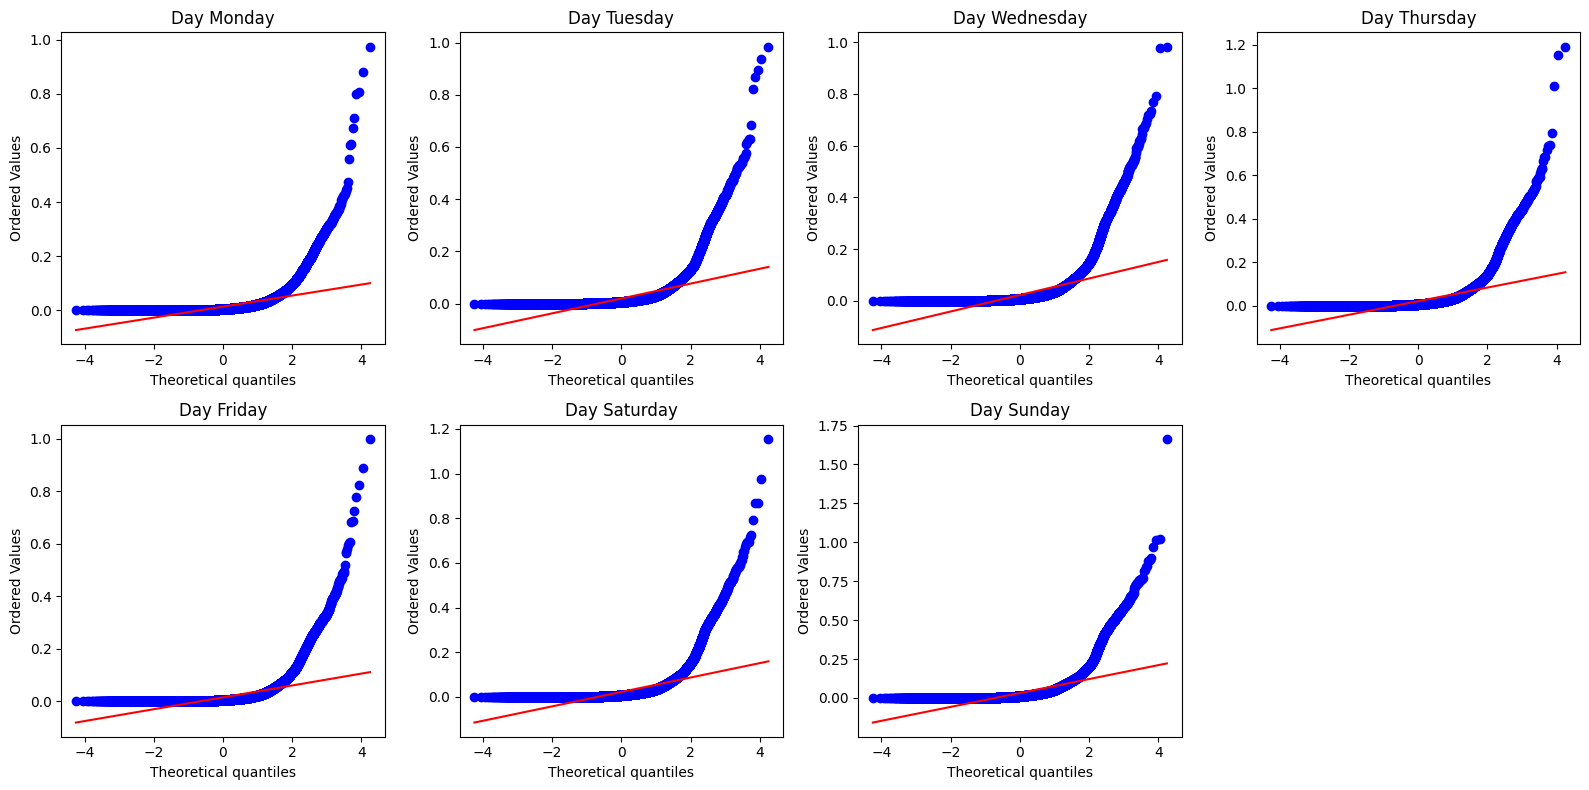


--- Normality Check for Donations Per Capita by State ---
State Johor: Anderson-Darling Stat = 3310.3623
  Does NOT appear normally distributed (stat >= 0.7870)
State Kedah: Anderson-Darling Stat = 2960.0641
  Does NOT appear normally distributed (stat >= 0.7870)
State Kelantan: Anderson-Darling Stat = 3963.8422
  Does NOT appear normally distributed (stat >= 0.7870)
State Melaka: Anderson-Darling Stat = 3114.4801
  Does NOT appear normally distributed (stat >= 0.7870)
State Negeri Sembilan: Anderson-Darling Stat = 3396.0769
  Does NOT appear normally distributed (stat >= 0.7870)
State Pahang: Anderson-Darling Stat = 4259.7055
  Does NOT appear normally distributed (stat >= 0.7870)
State Perak: Anderson-Darling Stat = 2915.0494
  Does NOT appear normally distributed (stat >= 0.7870)
State Pulau Pinang: Anderson-Darling Stat = 4332.8399
  Does NOT appear normally distributed (stat >= 0.7870)
State Sabah: Anderson-Darling Stat = 3570.8126
  Does NOT appear normally distributed (stat >= 

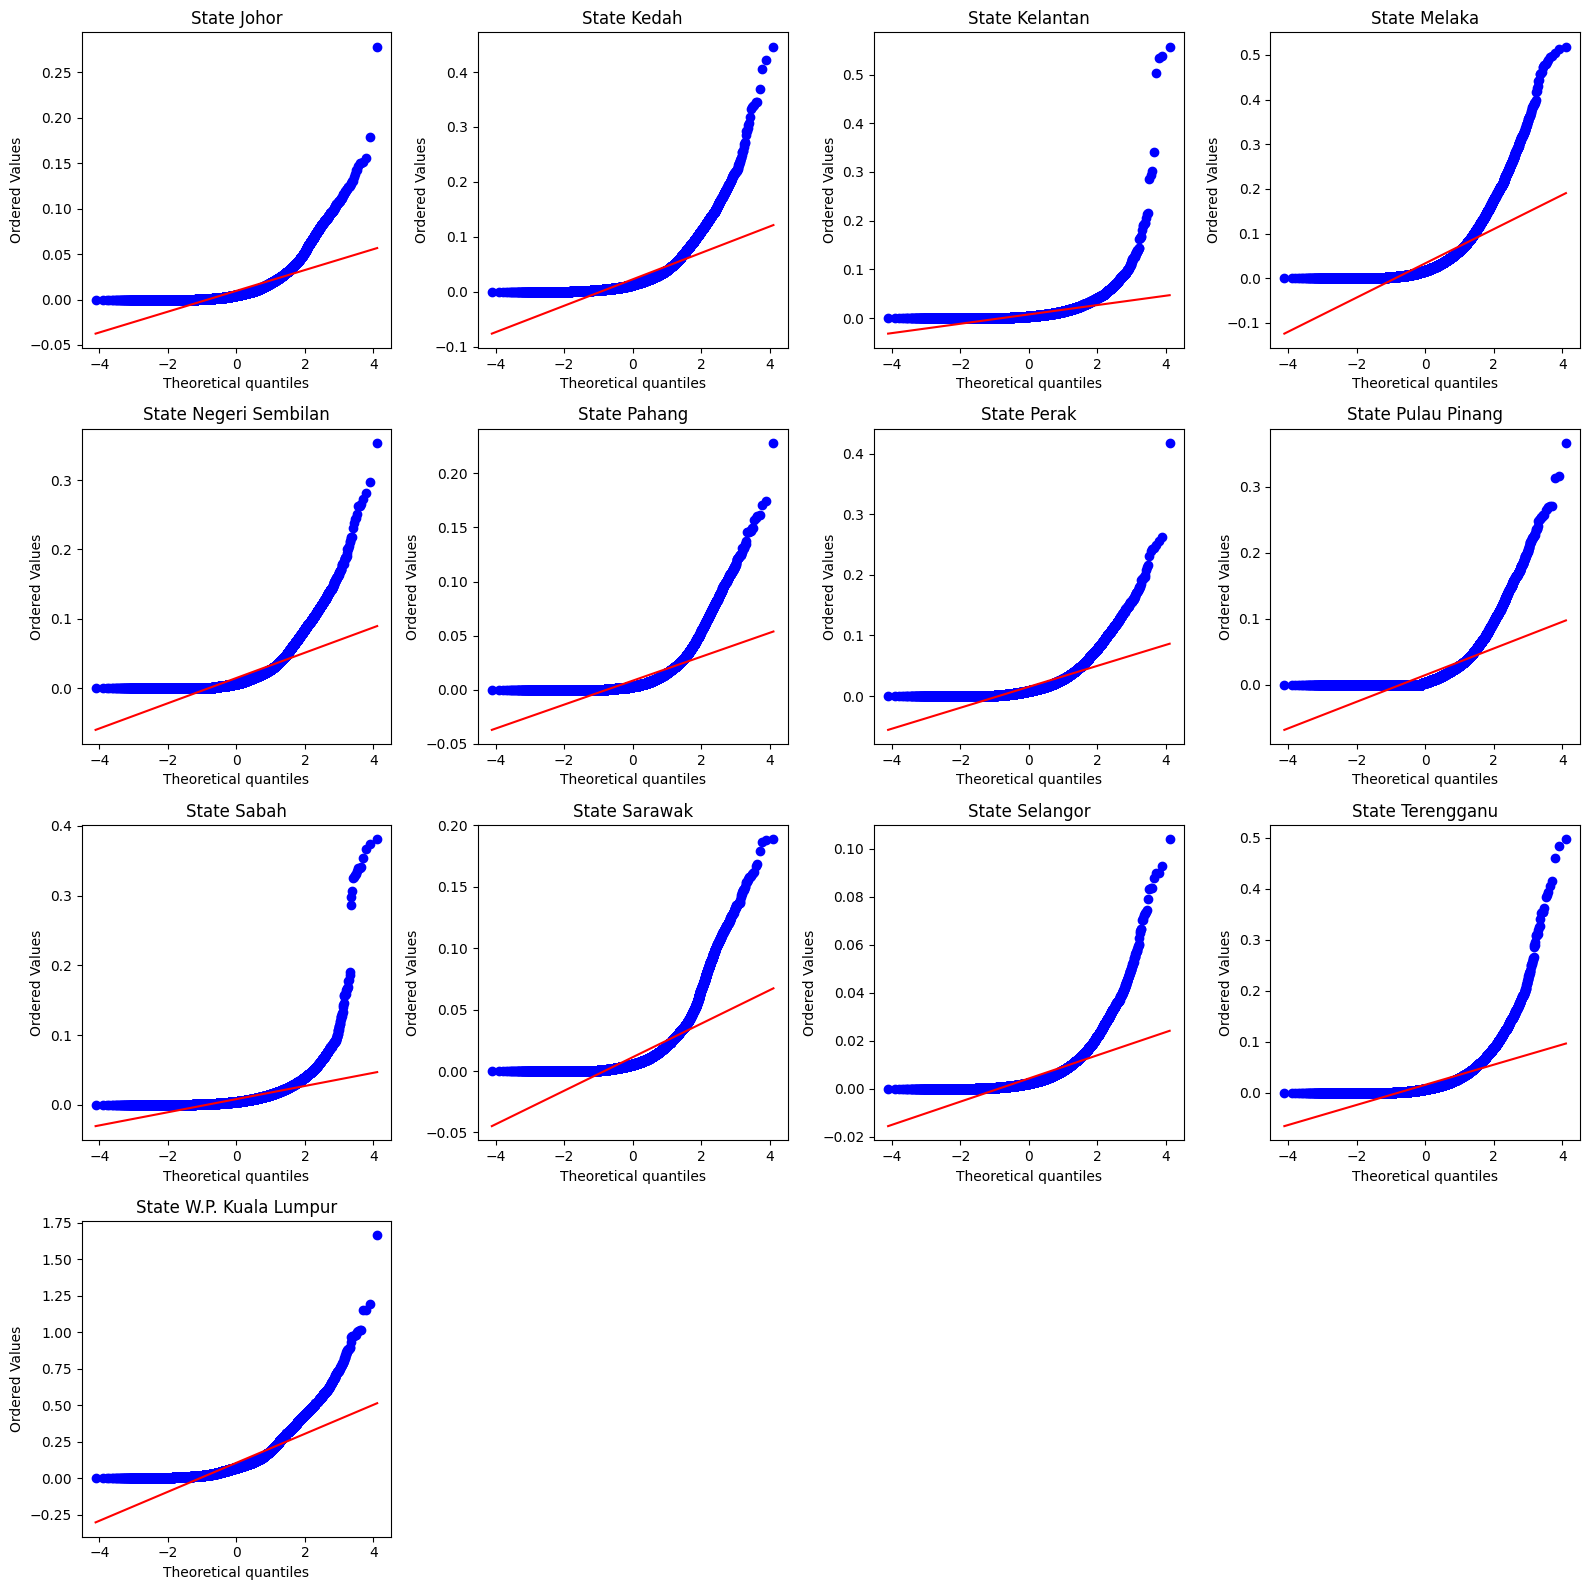

In [ ]:
from scipy.stats import anderson
import matplotlib.pyplot as plt
import statsmodels.api as sm
import warnings

# Assuming 'df_merged' DataFrame with 'donations_per_capita', 'month', 'dayofweek', and 'state' is available

# --- Anderson-Darling Test and Q-Q Plots by Month ---
print("--- Normality Check for Donations Per Capita by Month ---")
months = sorted(df_merged['month'].unique())
n_months = len(months)
n_cols_month = 4
n_rows_month = (n_months + n_cols_month - 1) // n_cols_month # Calculate number of rows

fig_month, axes_month = plt.subplots(nrows=n_rows_month, ncols=n_cols_month, figsize=(n_cols_month * 4, n_rows_month * 4))
axes_month = axes_month.flatten()

for i, month in enumerate(months):
    month_data = df_merged[df_merged['month'] == month]['donations_per_capita'].dropna().values
    ax = axes_month[i]

    if len(month_data) > 7: # Anderson-Darling requires N > 7
        try:
            # Suppress UserWarning for Anderson due to potential low variance/ties
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                result = anderson(month_data)
                print(f"Month {month}: Anderson-Darling Stat = {result.statistic:.4f}")
                # Interpretation at 5% significance level (index 2)
                if result.statistic < result.critical_values[2]:
                    print(f"  Appears normally distributed (stat < {result.critical_values[2]:.4f})")
                else:
                     print(f"  Does NOT appear normally distributed (stat >= {result.critical_values[2]:.4f})")
        except ValueError:
             print(f"Month {month}: Could not perform Anderson-Darling test.")
    else:
        print(f"Month {month}: Not enough data for Anderson-Darling test (N={len(month_data)}).")

    # Q-Q Plot
    if len(month_data) >= 3: # Q-Q plot requires at least 3 points
        probplot(month_data, dist="norm", plot=ax)
        ax.set_title(f'Month {month}')
    else:
         ax.set_title(f'Month {month} (Not enough data)')
         ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Hide any unused subplots
for j in range(i + 1, len(axes_month)):
    fig_month.delaxes(axes_month[j])

plt.tight_layout()
plt.show()

# --- Anderson-Darling Test and Q-Q Plots by Day of Week ---
print("\n--- Normality Check for Donations Per Capita by Day of Week ---")
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
n_days = len(day_order)
n_cols_day = 4
n_rows_day = (n_days + n_cols_day - 1) // n_cols_day # Calculate number of rows

fig_day, axes_day = plt.subplots(nrows=n_rows_day, ncols=n_cols_day, figsize=(n_cols_day * 4, n_rows_day * 4))
axes_day = axes_day.flatten()

for i, day in enumerate(day_order):
    day_data = df_merged[df_merged['dayofweek'] == day]['donations_per_capita'].dropna().values
    ax = axes_day[i]

    if len(day_data) > 7: # Anderson-Darling requires N > 7
        try:
            # Suppress UserWarning for Anderson due to potential low variance/ties
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                result = anderson(day_data)
                print(f"Day {day}: Anderson-Darling Stat = {result.statistic:.4f}")
                 # Interpretation at 5% significance level (index 2)
                if result.statistic < result.critical_values[2]:
                    print(f"  Appears normally distributed (stat < {result.critical_values[2]:.4f})")
                else:
                     print(f"  Does NOT appear normally distributed (stat >= {result.critical_values[2]:.4f})")
        except ValueError:
            print(f"Day {day}: Could not perform Anderson-Darling test.")
    else:
        print(f"Day {day}: Not enough data for Anderson-Darling test (N={len(day_data)}).")

    # Q-Q Plot
    if len(day_data) >= 3: # Q-Q plot requires at least 3 points
        probplot(day_data, dist="norm", plot=ax)
        ax.set_title(f'Day {day}')
    else:
         ax.set_title(f'Day {day} (Not enough data)')
         ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Hide any unused subplots
for j in range(i + 1, len(axes_day)):
    fig_day.delaxes(axes_day[j])

plt.tight_layout()
plt.show()


# --- Anderson-Darling Test and Q-Q Plots by State ---
print("\n--- Normality Check for Donations Per Capita by State ---")
states = sorted(df_merged['state'].unique())
n_states = len(states)
n_cols_state = 4
n_rows_state = (n_states + n_cols_state - 1) // n_cols_state # Calculate number of rows

fig_state, axes_state = plt.subplots(nrows=n_rows_state, ncols=n_cols_state, figsize=(n_cols_state * 4, n_rows_state * 4))
axes_state = axes_state.flatten()

for i, state in enumerate(states):
    state_data = df_merged[df_merged['state'] == state]['donations_per_capita'].dropna().values
    ax = axes_state[i]

    if len(state_data) > 7: # Anderson-Darling requires N > 7
        try:
            # Suppress UserWarning for Anderson due to potential low variance/ties
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", UserWarning)
                result = anderson(state_data)
                print(f"State {state}: Anderson-Darling Stat = {result.statistic:.4f}")
                 # Interpretation at 5% significance level (index 2)
                if result.statistic < result.critical_values[2]:
                    print(f"  Appears normally distributed (stat < {result.critical_values[2]:.4f})")
                else:
                     print(f"  Does NOT appear normally distributed (stat >= {result.critical_values[2]:.4f})")
        except ValueError:
            print(f"State {state}: Could not perform Anderson-Darling test.")
    else:
        print(f"State {state}: Not enough data for Anderson-Darling test (N={len(state_data)}).")

    # Q-Q Plot
    if len(state_data) >= 3: # Q-Q plot requires at least 3 points
        probplot(state_data, dist="norm", plot=ax)
        ax.set_title(f'State {state}')
    else:
         ax.set_title(f'State {state} (Not enough data)')
         ax.text(0.5, 0.5, 'Not enough data', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


# Hide any unused subplots
for j in range(i + 1, len(axes_state)):
    fig_state.delaxes(axes_state[j])

plt.tight_layout()
plt.show()